In [5]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as patches
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

### Boat Problem: Simplified Sailing

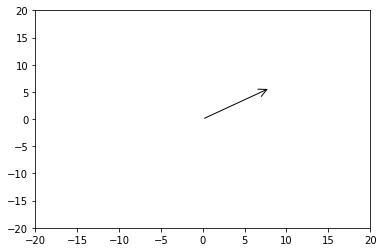

In [3]:
### Wind function ###
tf = 100
t = np.linspace(0, tf, 100)

# Constant wind
av_speed = 8
constant_wind = lambda t: av_speed*np.ones_like(t)
constant_x_wind = constant_wind(t)

# Variable wind
amplitude = 4
frequency = 0.2
wind_func = lambda t: av_speed + amplitude * np.sin(frequency * t)
variable_x_wind = wind_func(t)
variable_y_wind = constant_wind(t) * np.random.random(size=len(t))

# Plot wind over time
fig, ax = plt.subplots()

ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)

# Initialize vec
wind_vec = FancyArrowPatch((0, 0), (0, 0), arrowstyle='->', mutation_scale=20)
ax.add_patch(wind_vec)

def animation_function(t):
    x = variable_x_wind[t]
    y = variable_y_wind[t]

    wind_vec.set_positions((0, 0), (x, y))
    return wind_vec
    
animation = FuncAnimation(fig, func=animation_function, frames=np.arange(len(t)), interval=tf)
animation.save("wind.mp4")

<video src="wind.mp4" controls>

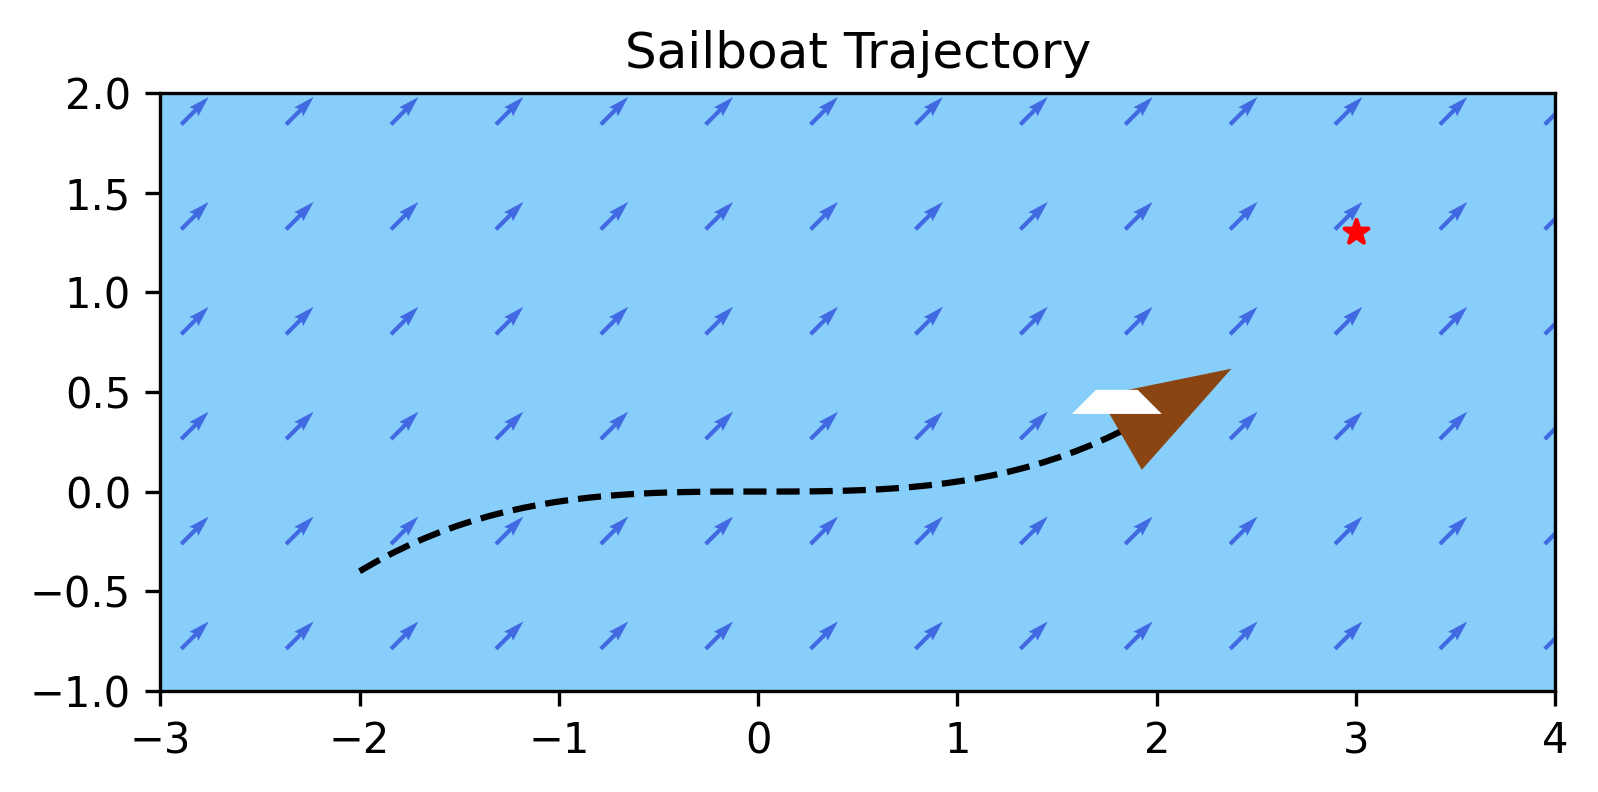

In [94]:
### Example Code to Plot boat in the Water ###

# Made-up Trajectory
x = np.linspace(-2, 2)
y = 0.05 * x**3

def create_boat(center=(0, 0), size=1.0, phi=0, theta=0):
    """Make a little triangle that looks like a boat. Also make a little sail."""
    # Make clockwise rotations positive theta
    theta = -theta
    # Make between -2*np.pi and 2*np.pi
    if theta > 0:
        theta = theta % (2 * np.pi)
    else:
        theta = theta % (-2 * np.pi)
    # Make rotations beyond 90 degrees go to the other side
    if theta < -np.pi / 2:
        theta = -theta - np.pi / 2
    if theta > np.pi / 2:
        theta = -theta + np.pi / 2

    # Get vertices relative to origin (boat starts facing right)
    triangle = np.array([
        [2, 0], # Right vertex
        [-1, 1], # Bottom left
        [-1, -1] # Bottom right
    ]) * size

    # Port side sail
    if theta < 0 and theta >= -np.pi:
        sail = np.array([
            [0, 0],
            [-0.5, 0.5],
            [-1.5, 0.5],
            [-2, 0]
        ]) * size
    # Starboard side sail
    else:
        sail = np.array([
            [0, 0],
            [-0.5, -0.5],
            [-1.5, -0.5],
            [-2, 0]
        ]) *  size

    # Rotation matrix
    rotation_matrix = lambda angle: np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])

    # Rotate and translate
    rotated_boat = rotation_matrix(phi) @ triangle.T
    translated_boat = rotated_boat.T + np.array(center)
    rotated_sail = rotation_matrix(phi + theta) @ sail.T
    translated_sail = rotated_sail.T + np.array(center)
    
    return translated_boat, translated_sail

def make_plot(x, y, phi, theta):
    """
    Plot our boat given a trajectory of x positions, a trajectory of y 
    positions, the final angle of the boat, and the final angle of the 
    sail.
    """
    # Plot
    plt.title("Sailboat Trajectory")
    ax = plt.gca()
    ax.set_facecolor("lightskyblue") # background color
    ax.plot(x, y, "k--", zorder=1) # plot trajectory

    # Plot boat
    triangle_coords, sail_coords = create_boat(center=(x[-1], y[-1]), size=0.2, phi=phi, theta=theta)
    triangle_patch = patches.Polygon(triangle_coords, closed=True, color="saddlebrown", zorder=2)
    sail_patch = patches.Polygon(sail_coords, closed=True, color="white", zorder=3)
    ax.add_patch(triangle_patch)
    ax.add_patch(sail_patch)

    # Plot target
    ax.scatter(3, 1.3, marker="*", c="r")

    # Plot wind vector field
    x, y = np.meshgrid(np.linspace(-5, 5, 20), np.linspace(-5, 5, 20))
    u = 0.25 * np.ones_like(x) # x component of wind
    v = 0.25 * np.ones_like(y) # y component of wind
    plt.quiver(x, y, u, v, color="royalblue", zorder=1)

    ax.set_xlim(-3, 4)
    ax.set_ylim(-1, 2)
    plt.gca().set_aspect('equal')
    plt.show()

make_plot(x, y, np.pi/6, -2*np.pi/3)

In [ ]:
### Trying to solve the simplest problem ###

wind_x = lambda x: 0.25
wind_y = lambda y: 0.1

def optimal_sail_control(wind_x, wind_y):
    """Optimal control solved for analytically in the simple case."""
    return 0.5 * np.arctan(-wind_y / wind_x)

def state_equation(t, s):
    x, y, v_x, v_y = s
    return np.array([
        v_x,
        v_y,
        np.sin(optimal_sail_control(wind_x(x), wind_y(y))) * np.sin(optimal_sail_control(wind_x(x), wind_y(y))) * wind_x(x),
        0
    ])

initial_state

### Coding up the 1D optimal theta for simplified sailing

In [103]:
### Wind function ###
tf = 90
t = np.linspace(0, tf, 100)
t_span = (0, tf)

# Constant wind
av_speed = .2
constant_wind = lambda t: av_speed*np.ones_like(t)
constant_x_wind = constant_wind(t)

# Variable wind
amplitude = .1
frequency = 0.02
wind_funcx = lambda t: av_speed + amplitude * np.sin(frequency * t)
wind_funcy = lambda t: constant_wind(t) * np.random.random(size=1)
# wind_funcx = lambda t: 2.0
# wind_funcy = lambda t: .5
variable_x_wind = wind_func(t)
variable_y_wind = constant_wind(t) * np.random.random(size=1)

mu = .98 # Add some drag proportional to velocity
# Control sail
optimal_theta = lambda wx, wy: (np.arctan(wx/wy))
bad_theta = lambda wx, wy: 3*np.arctan(wx/wy)

def ode1(t, state):
    '''Define the optimal ode system'''
    x, y, vx, vy = state
    wx = wind_funcx(t)
    wy = wind_funcy(t)
    theta = optimal_theta(wx,wy)
    dx = 1
    dy = 0
    thing = wx*(np.sin(theta)**2)*dx +wx*np.sin(theta)*np.cos(theta)*dy + wy*np.cos(theta)*np.sin(theta)*dx + wy*(np.cos(theta)**2) * dx
    ax = thing*dx
    ay = thing*dy
    return np.array([vx - np.sign(vx)*mu*np.abs(vx),vy - vy*mu*np.abs(vy),ax[0],ay[0]])


def ode2(t, state):
    '''Define the sub_optimal ode system'''
    x, y, vx, vy = state
    wx = wind_funcx(t)
    wy = wind_funcy(t)
    theta = bad_theta(wx,wy)
    dx = 1
    dy = 0
    thing = wx*np.sin(theta)**2*dx +wx*np.sin(theta)*np.cos(theta)*dy + wy*np.cos(theta)*np.sin(theta)*dx + wy*np.cos(theta)**2 * dx
    ax = thing*dx # x acceleration
    ay = thing*dy # y acceleration
    return np.array([vx - np.sign(vx)*mu*np.abs(vx), vy - vy*mu*np.abs(vy), ax[0], ay[0]])


# Initial conditions
y0 = np.array([0, 0, 0, 0])
# Solving
sol1 = solve_ivp(ode1, t_span, y0, max_step=.01, dense_output=True)
sol2 = solve_ivp(ode2, t_span, y0, max_step=.01, dense_output=True)


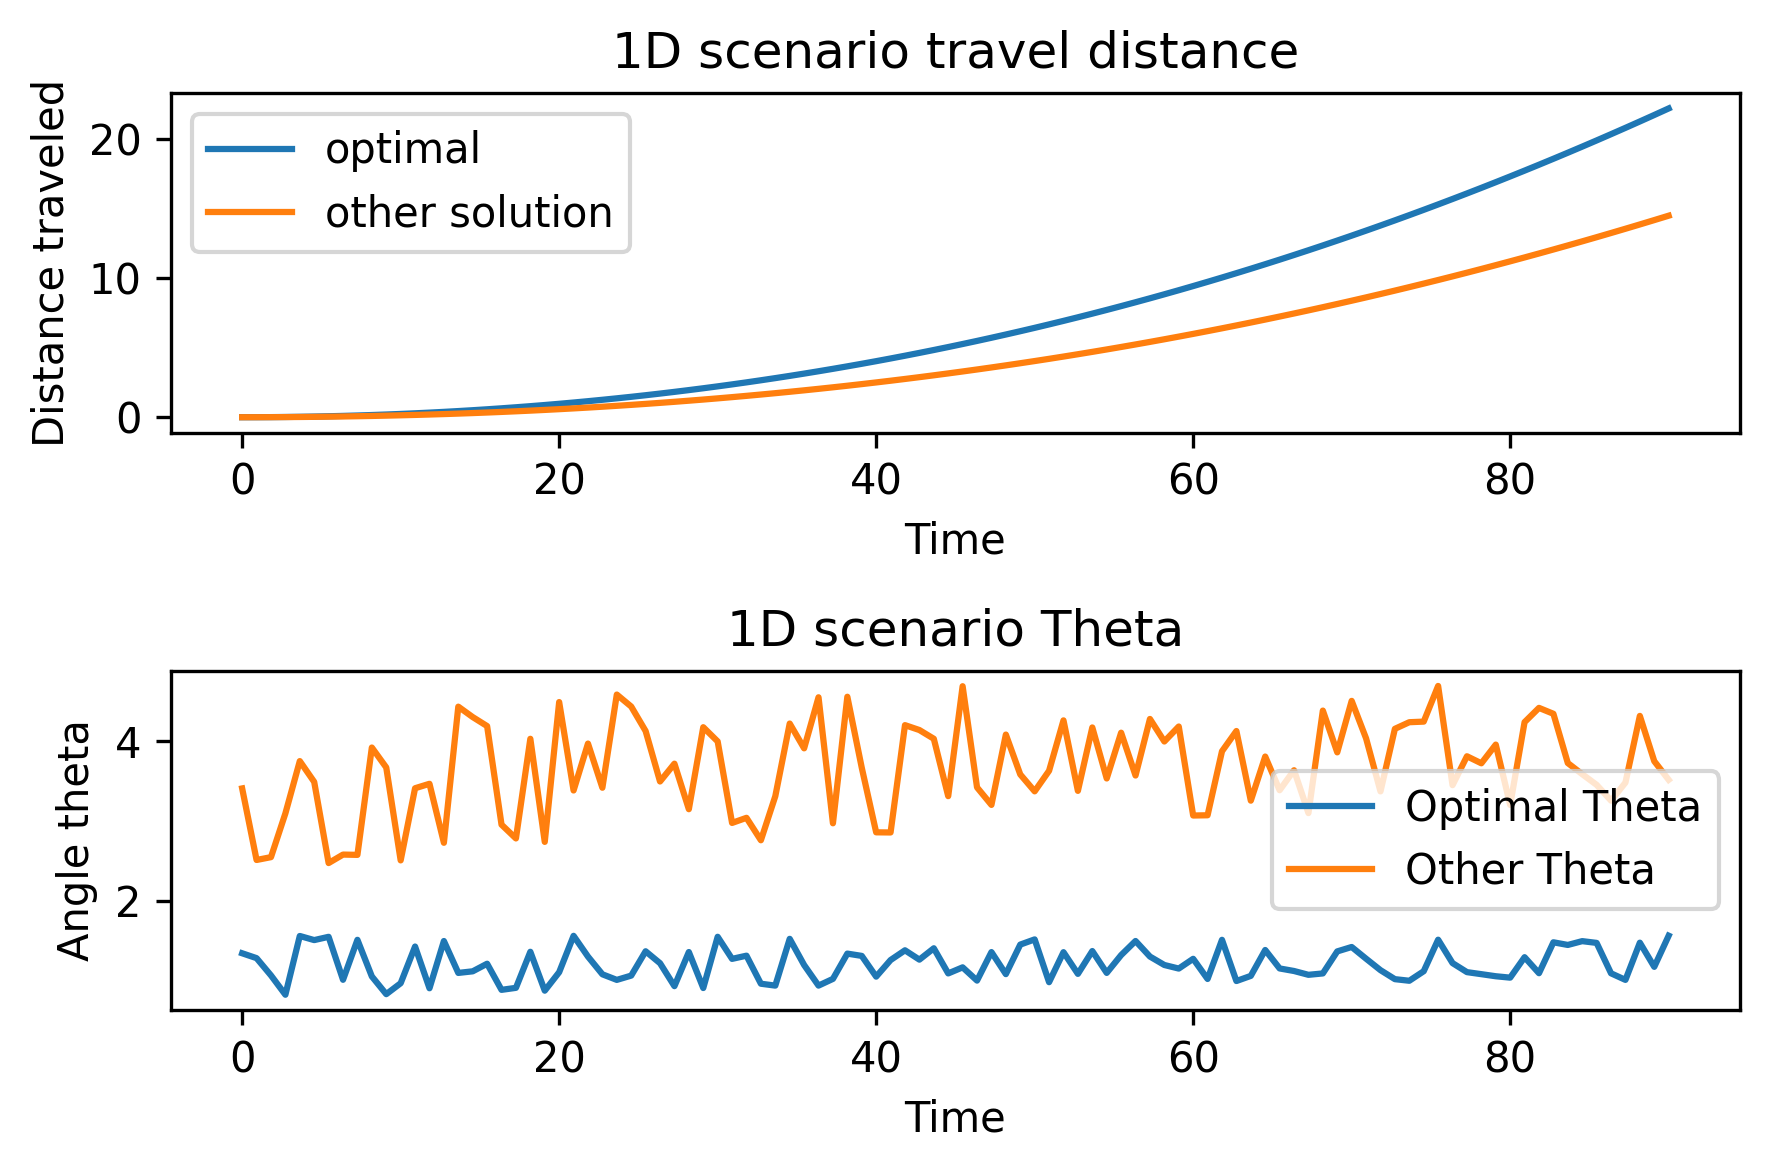

In [105]:
ts = np.linspace(0, tf, 100)
windx = wind_funcx(ts)
windy = wind_funcy(ts)
good_thetas = optimal_theta(windx,windy)
bad_thetas = bad_theta(windx,windy)

# Plotting Optimal
plt.subplot(2,1,1)
plt.plot(ts,sol1.sol(ts)[0], label = "optimal")
plt.plot(ts,sol2.sol(ts)[0], label = "other solution")
plt.legend()
plt.ylabel("Distance traveled")
plt.xlabel("Time")
plt.title("1D scenario travel distance")
plt.subplot(2, 1, 2)
plt.plot(ts, ([optimal_theta(wind_funcx(i),wind_funcy(i)) for i in ts]), label = "Optimal Theta")
plt.plot(ts, ([bad_theta(wind_funcx(i),wind_funcy(i)) for i in ts]), label = "Other Theta")
plt.ylabel("Angle theta")
plt.title("1D scenario Theta")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()

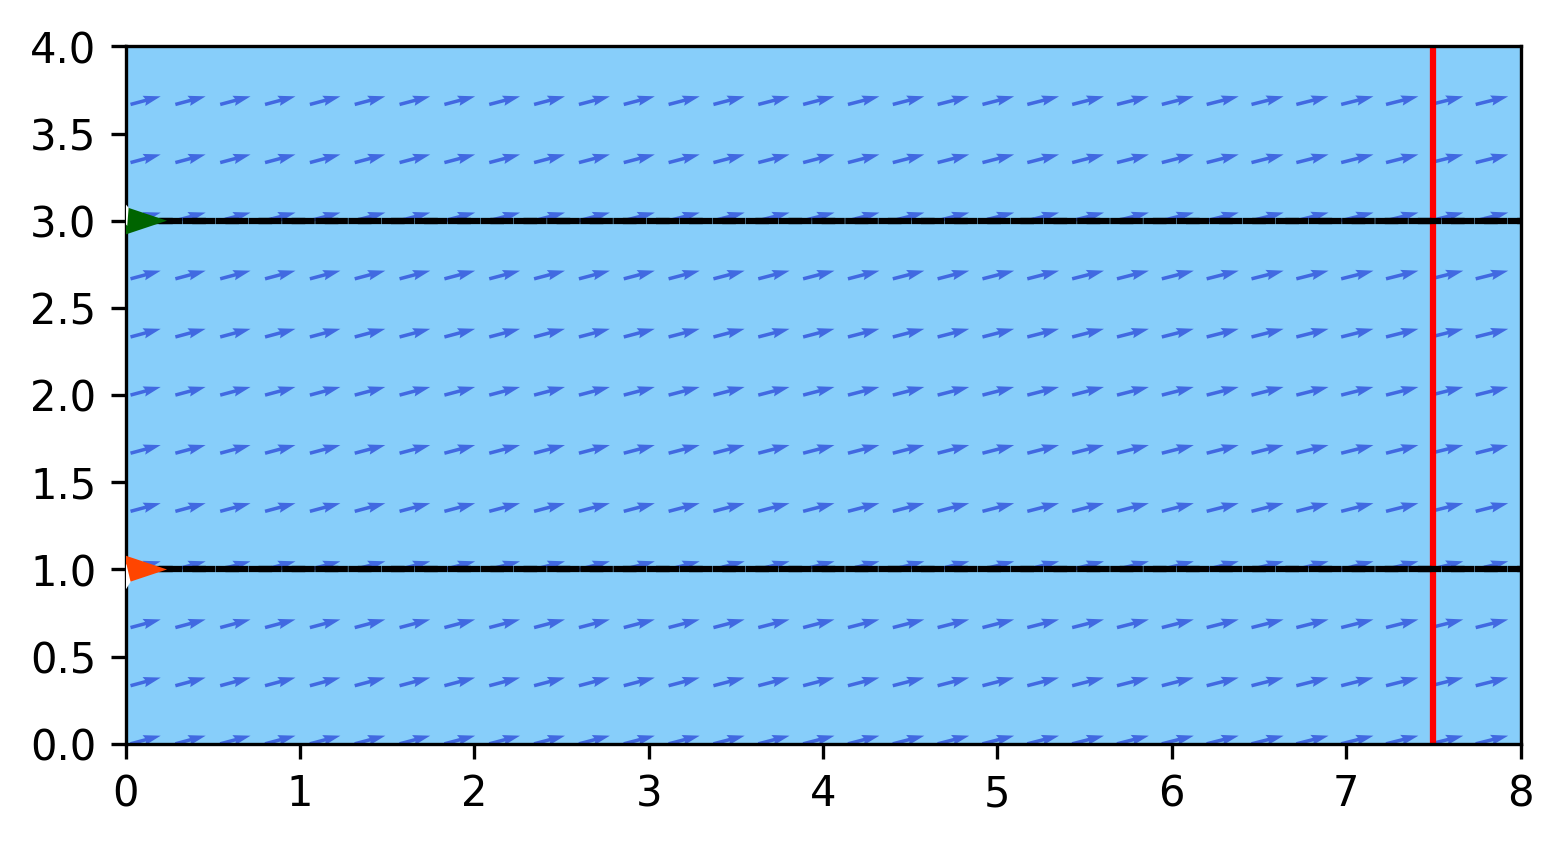

In [108]:
t = np.linspace(0, tf, 100)
#Initializing figure specs
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = plt.gca()
#print(sol1.sol(0)[0])
#Defining function
opt_checkpoints = []
sub_opt_checkpoints = []
def update(t):
    ax.clear()
    ax.set_xlim([0, 8])
    ax.set_ylim([0, 4])
    opt_checkpoints.append(sol1.sol(t)[0])
    Opt_checkpoints = np.array(opt_checkpoints)
    sub_opt_checkpoints.append(sol2.sol(t)[0])

    ### Plot ###
    ax.set_facecolor("lightskyblue") # background color

    # Plot finish
    ax.plot([7.5, 7.5], [0,7], zorder=2, c="red")

    # Plot boat paths
    ax.plot(opt_checkpoints, 3*np.ones_like(Opt_checkpoints), "k--", zorder=2)
    ax.plot(sub_opt_checkpoints, 1*np.ones_like(Opt_checkpoints), "k--", zorder=2)

    # Plot boat
    windx = wind_funcx(t)
    windy = wind_funcy(t)
    good_thetas = optimal_theta(windx,windy)
    bad_thetas = bad_theta(windx,windy)
    opt_triangle_coords, opt_sail_coords = create_boat(center=(opt_checkpoints[-1], 3), size=0.1, phi=0, theta=good_thetas[0])
    sub_triangle_coords, sub_sail_coords = create_boat(center=(sub_opt_checkpoints[-1], 1), size=0.1, phi=0, theta = bad_thetas[0])
    opt_triangle_patch = patches.Polygon(opt_triangle_coords, closed=True, color="darkgreen", zorder=3)
    sub_triangle_patch = patches.Polygon(sub_triangle_coords, closed=True, color="orangered", zorder=3)
    opt_sail_patch = patches.Polygon(opt_sail_coords, closed=True, color="white", zorder=4)
    sub_sail_patch = patches.Polygon(sub_sail_coords, closed=True, color="white", zorder=4)
    ax.add_patch(opt_triangle_patch)
    ax.add_patch(opt_sail_patch)
    ax.add_patch(sub_triangle_patch)
    ax.add_patch(sub_sail_patch)

    # Plot wind
    X, Y = np.meshgrid(np.linspace(-1, 8, 36), np.linspace(-1, 4, 16))
    u = wind_funcx(X)
    v = wind_funcy(Y)
    ax.quiver(X, Y, u, v, color="royalblue", zorder=1)

    plt.gca().set_aspect('equal')

animation = FuncAnimation(fig, update, frames=t)
animation.save("race.mp4")

<video src="race.mp4" controls>

### Motorboat Problem

In [2]:
def create_boat(center=(0, 0), size=1.0, theta=0):
    """Make a little triangle that looks like a boat."""
    # # Make between -2*np.pi and 2*np.pi
    # if theta > 0:
    #     theta = theta % (2 * np.pi)
    # else:
    #     theta = theta % (-2 * np.pi)
    # # Make rotations beyond 90 degrees go to the other side
    # if theta < -np.pi / 2:
    #     theta = -theta - np.pi / 2
    # if theta > np.pi / 2:
    #     theta = -theta + np.pi / 2

    # Get vertices relative to origin (boat starts facing right)
    triangle = np.array([
        [2, 0], # Right vertex
        [-1, 1], # Bottom left
        [-1, -1] # Bottom right
    ]) * size

    # Rotation matrix
    rotation_matrix = lambda angle: np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])

    # Rotate and translate
    rotated_boat = rotation_matrix(theta) @ triangle.T
    translated_boat = rotated_boat.T + np.array(center)
    
    return translated_boat

NpzFile 'data/currents.npz' with keys: x, u, h, y


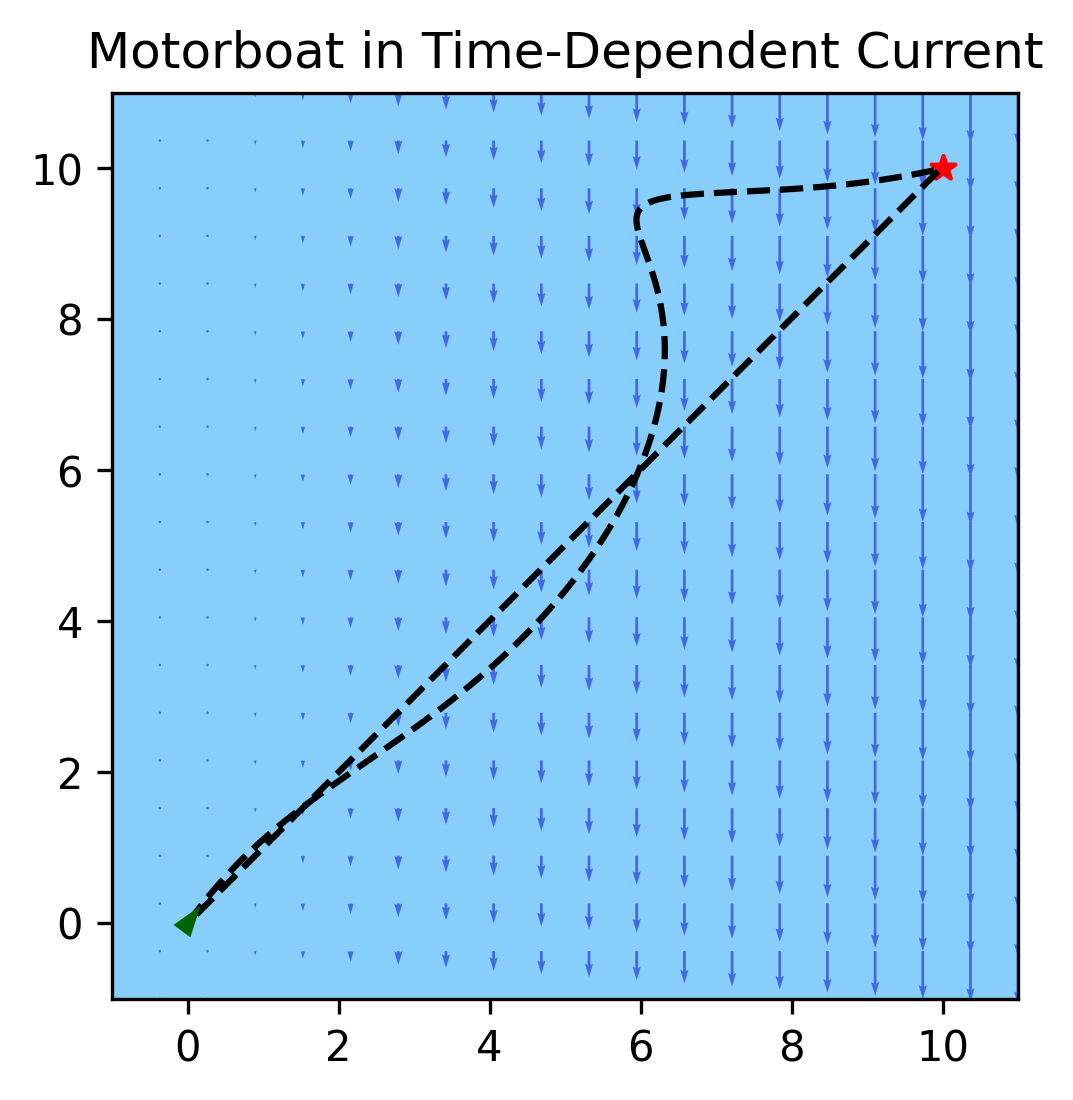

In [ ]:
### Currents ###

# Optimal solution calculated in Julia
data = np.load("data/currents.npz")
print(data)

dt = data['h']
t_steps = 1000
t = dt * np.arange(t_steps)
indices = np.arange(t_steps)
t_to_index = {k: v for k, v in zip(t, indices)}

C1 = lambda x, y, t: 0.1 * y * np.sin(0.5*t)
C2 = lambda x, y, t: -0.1 * x * np.cos(0.5*t)

# Boundaries for plot
bottom_left = (0, 0)
top_right = (10, 10)

x_path = []
y_path = []
fig = plt.figure()
def update(t):
    ax = plt.gca()
    ax.clear()
    ax.set_title("Motorboat in Time-Dependent Current")
    ax.set_xlim(bottom_left[0] - 1, top_right[0] + 1)
    ax.set_ylim(bottom_left[1] - 1, top_right[1] + 1)
    x_path.append(data['x'][t_to_index[t]])
    y_path.append(data['y'][t_to_index[t]])

    ### Plot ###
    ax.set_facecolor("lightskyblue") # background color

    # Plot finish
    ax.scatter(10, 10, c="red", marker="*", zorder=2)

    # Plot boat path
    ax.plot(x_path, y_path, "k--", zorder=2)

    # Plot boat
    angle = data['u'][t_to_index[t]]
    opt_triangle_coords = create_boat(center=(x_path[-1], y_path[-1]), size=0.1, theta=angle)
    opt_triangle_patch = patches.Polygon(opt_triangle_coords, closed=True, color="darkgreen", zorder=3)
    ax.add_patch(opt_triangle_patch)

    # Plot currents
    x, y = np.meshgrid(np.linspace(bottom_left[0] - 1, top_right[0] + 1, 20), np.linspace(bottom_left[1] - 1, top_right[1] + 1, 20))
    u = C1(x, y, t) # x component of current
    v = C2(x, y, t) # y component of current
    ax.quiver(x, y, u, v, color="royalblue", zorder=1)

    plt.gca().set_aspect('equal')

animation = FuncAnimation(fig, func=update, frames=t[:-1], interval=10)
animation.save("results/motor.mp4", dpi=300)


<video src="results/motor.mp4" controls> 

NpzFile 'data/currents.npz' with keys: x, u, h, y


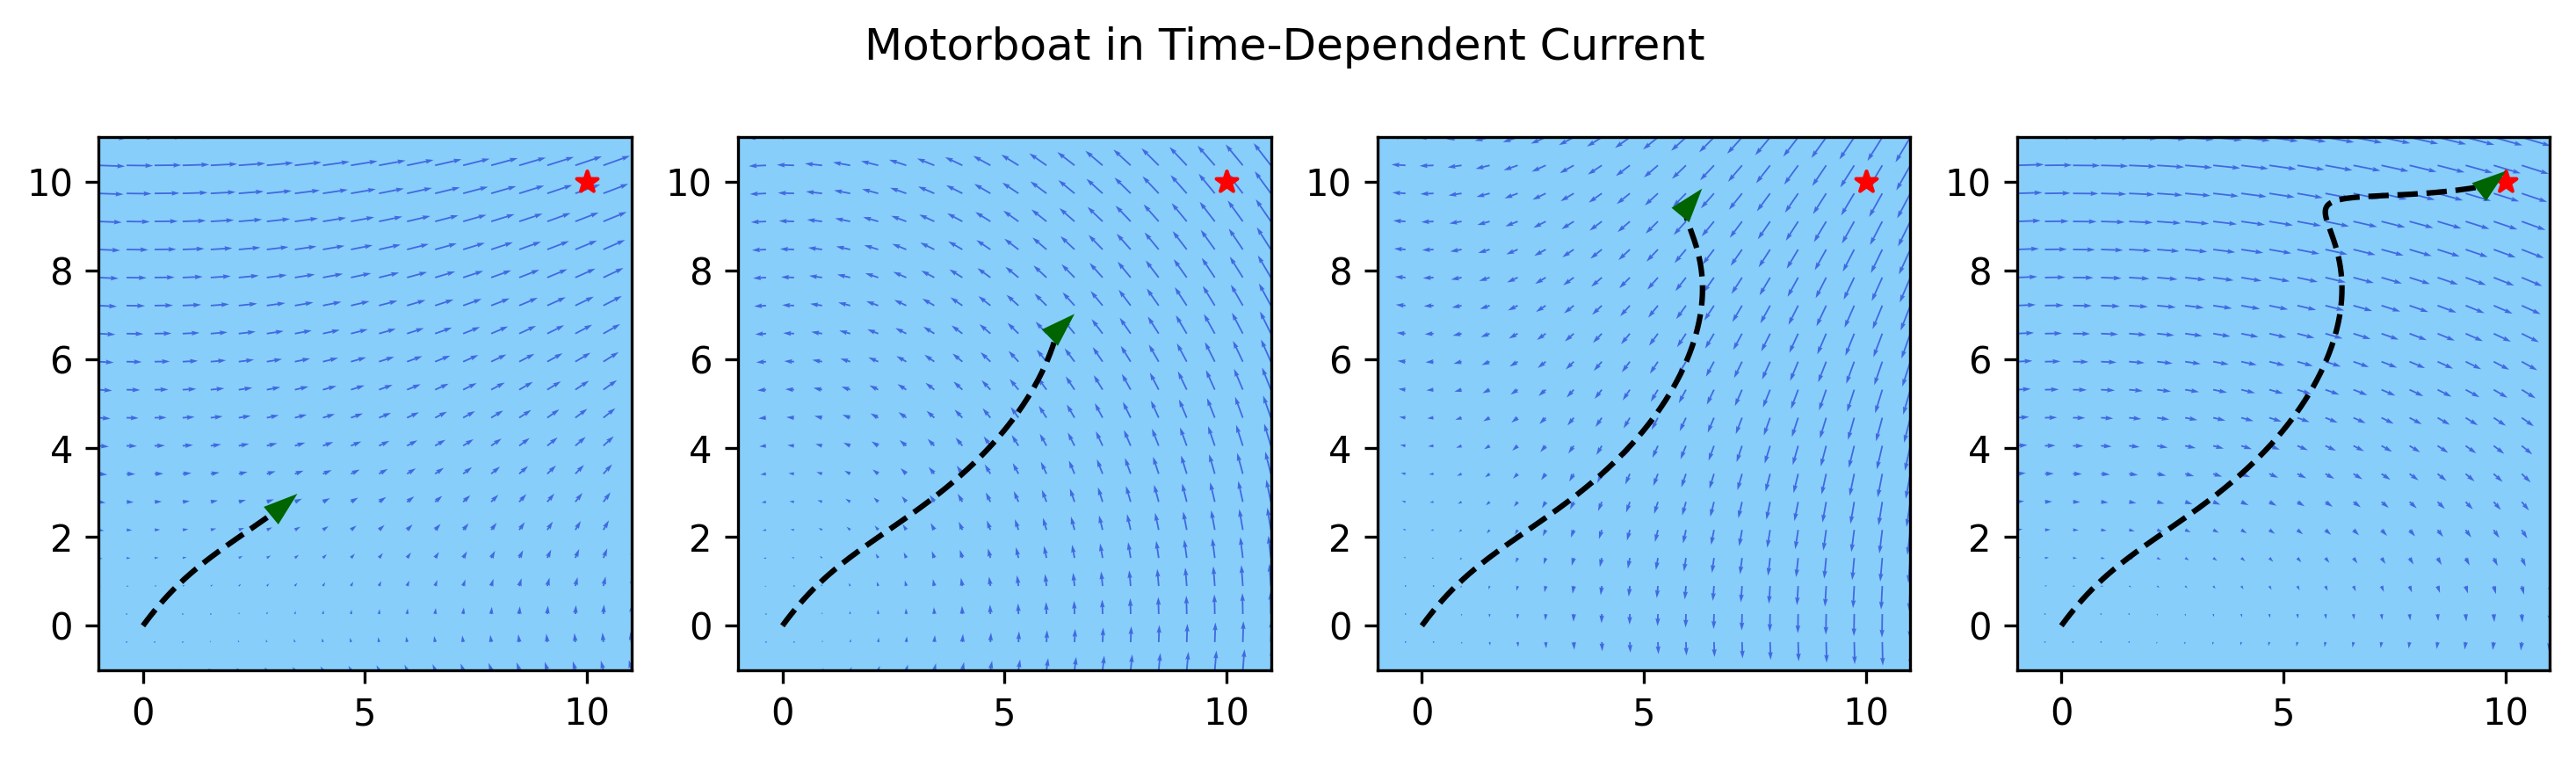

In [25]:
# Get still frames side by side for simple motorboat problem

# Optimal solution calculated in Julia
data = np.load("data/currents.npz")
print(data)

dt = data['h']
t_steps = 1000
t = dt * np.arange(t_steps)
indices = np.arange(t_steps)
t_to_index = {k: v for k, v in zip(t, indices)}
index_to_t = dict()
for time in t_to_index.keys():
    index_to_t[t_to_index[time]] = time

C1 = lambda x, y, t: 0.1 * y * np.sin(0.5*t)
C2 = lambda x, y, t: -0.1 * x * np.cos(0.5*t)

# Boundaries for plot
bottom_left = (0, 0)
top_right = (10, 10)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
plt.suptitle("Motorboat in Time-Dependent Current")

for i in range(4):
    if i == 0:
        idx = 250
        t = index_to_t[idx]
    elif i == 1:
        idx = 500
        t = index_to_t[idx]
    elif i == 2:
        idx = 750
        t = index_to_t[idx]
    elif i == 3:
        idx = 985
        t = index_to_t[idx]

    axs[i].set_xlim(bottom_left[0] - 1, top_right[0] + 1)
    axs[i].set_ylim(bottom_left[1] - 1, top_right[1] + 1)
    x_path = data['x'][:t_to_index[t]]
    y_path = data['y'][:t_to_index[t]]
    axs[i].set_facecolor("lightskyblue") # background color
    axs[i].scatter(10, 10, c="red", marker="*", zorder=2)
    axs[i].plot(x_path, y_path, "k--", zorder=2)
    angle = data['u'][t_to_index[t]]
    opt_triangle_coords = create_boat(center=(x_path[-1], y_path[-1]), size=0.2, theta=angle)
    opt_triangle_patch = patches.Polygon(opt_triangle_coords, closed=True, color="darkgreen", zorder=3)
    axs[i].add_patch(opt_triangle_patch)
    x, y = np.meshgrid(np.linspace(bottom_left[0] - 1, top_right[0] + 1, 20), np.linspace(bottom_left[1] - 1, top_right[1] + 1, 20))
    u = C1(x, y, t) # x component of current
    v = C2(x, y, t) # y component of current
    axs[i].quiver(x, y, u, v, color="royalblue", zorder=1)

    axs[i].set_aspect('equal')
plt.show()

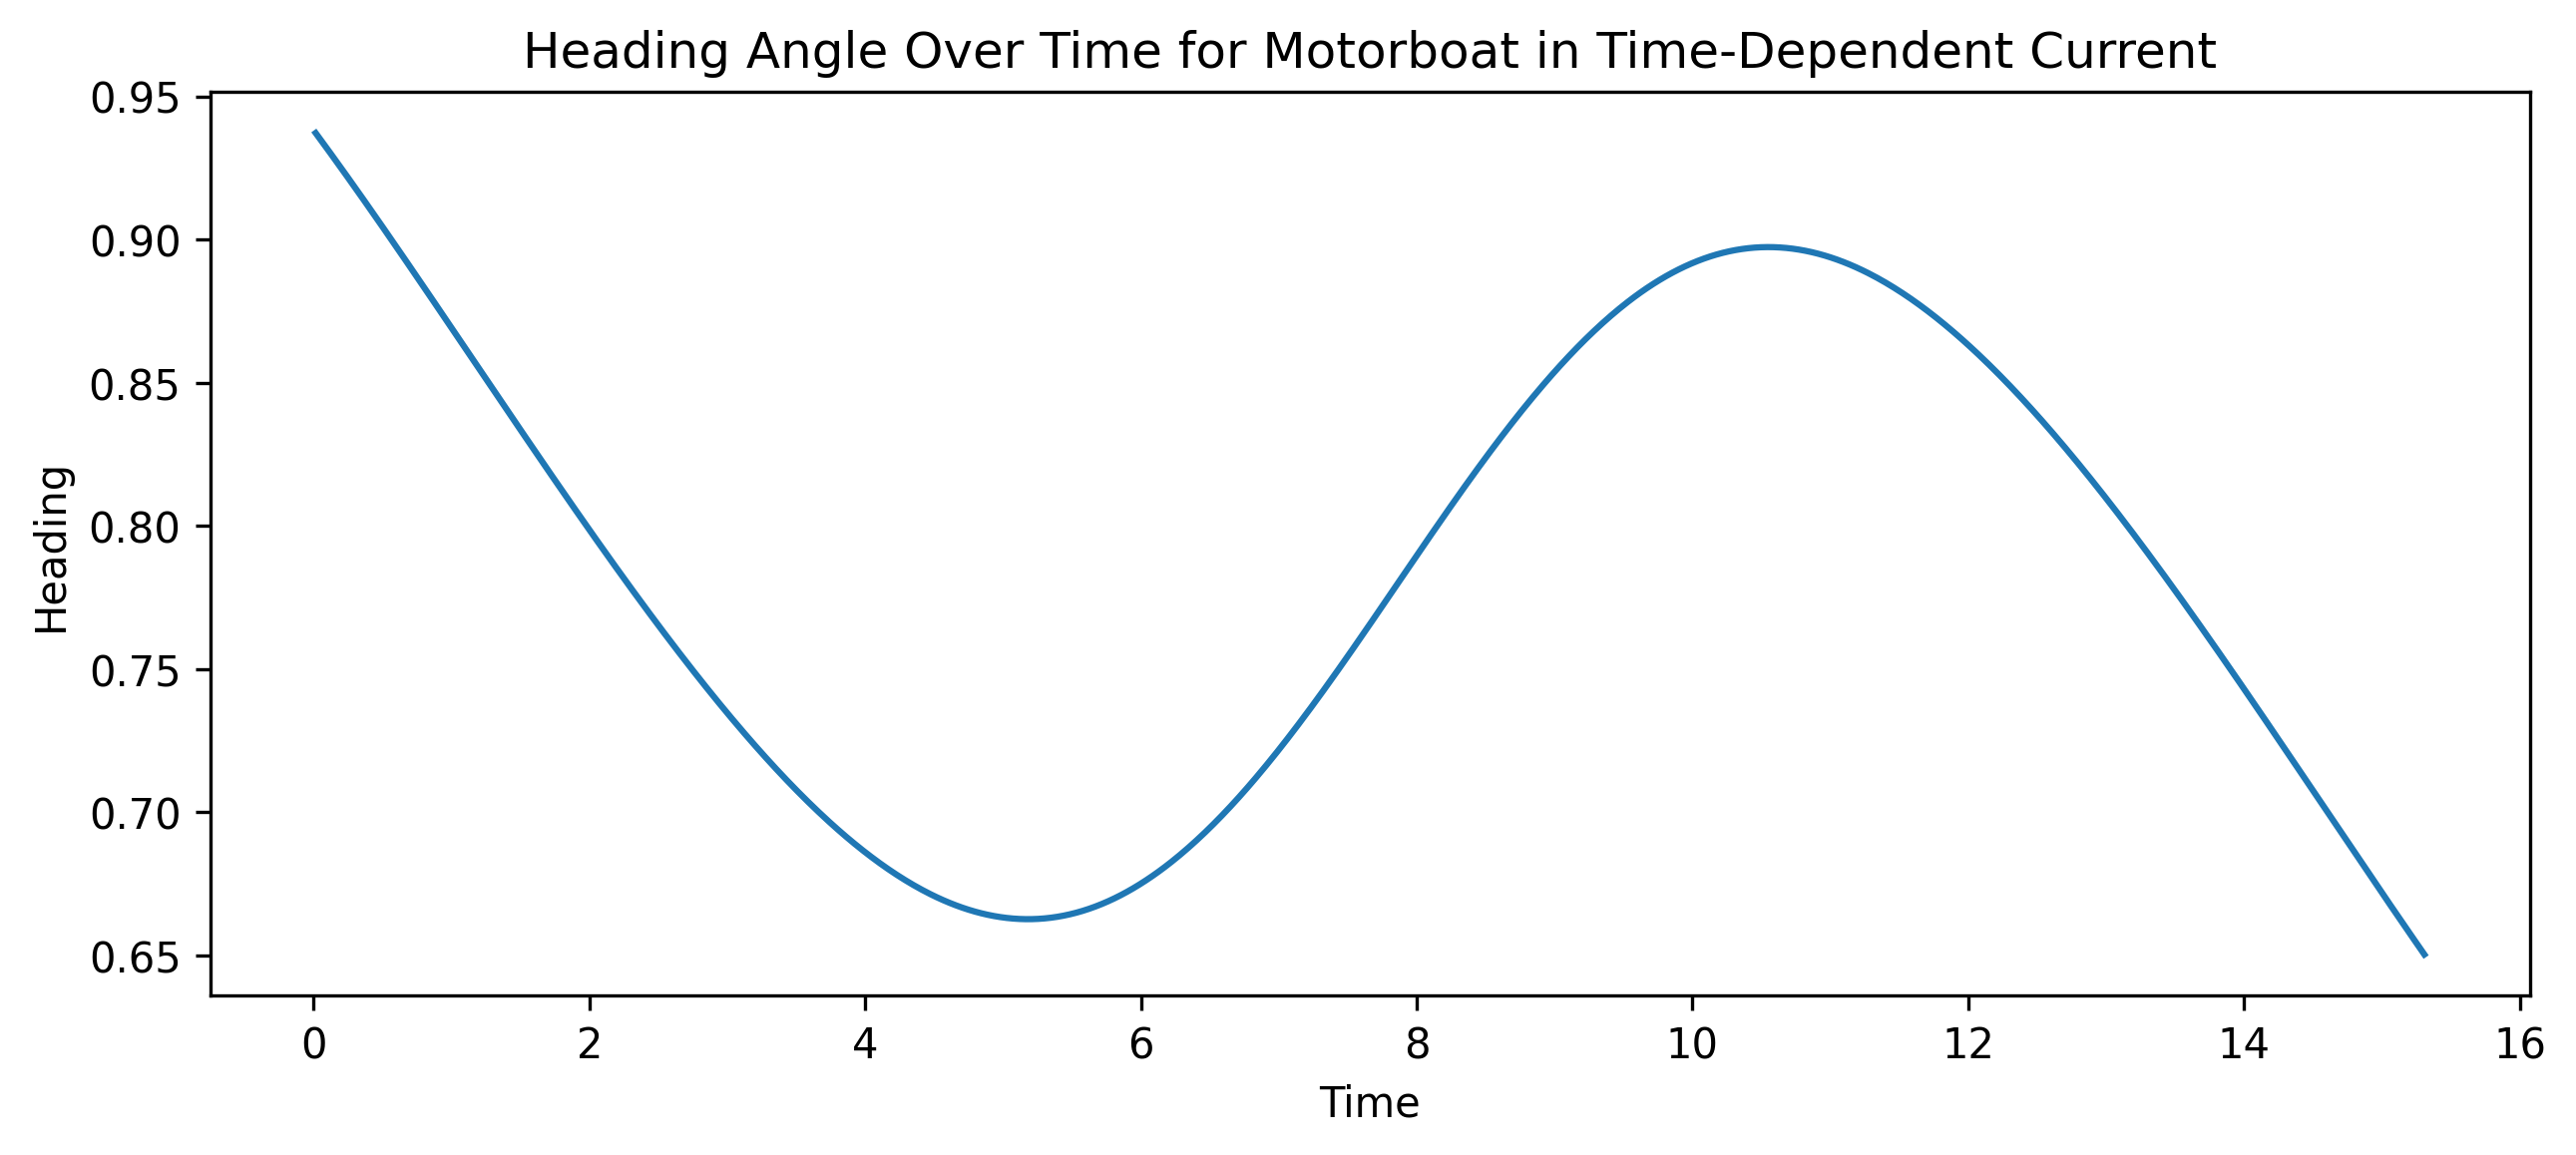

In [19]:
fig = plt.figure(figsize=(10, 4))
plt.title("Heading Angle Over Time for Motorboat in Time-Dependent Current")
plt.plot(t[1:], data['u'])
plt.xlabel("Time")
plt.ylabel("Heading")
plt.show()

In [27]:
# Optimal solution calculated in Julia
data = np.load("data/time-dependent-motorboat-high-cost.npz")
print(data)

dt = data['h']
t_steps = 100
t = dt * np.arange(t_steps)
indices = np.arange(t_steps)
t_to_index = {k: v for k, v in zip(t, indices)}

C1 = lambda x, y, t: 0.1 * y * np.sin(0.5*t)
C2 = lambda x, y, t: -0.1 * x * np.cos(0.5*t)

# Boundaries for plot
bottom_left = (0, 0)
top_right = (10, 10)

x_path = []
y_path = []
fig = plt.figure()
def update(t):
    ax = plt.gca()
    ax.clear()
    ax.set_title("Motor Boat with Time-Dependent Current,\nHigh Gas Cost, and Low Final Velocity")
    ax.set_xlim(bottom_left[0] - 1, top_right[0] + 1)
    ax.set_ylim(bottom_left[1] - 1, top_right[1] + 1)
    x_path.append(data['x'][t_to_index[t]])
    y_path.append(data['y'][t_to_index[t]])

    ### Plot ###
    ax.set_facecolor("lightskyblue") # background color

    # Plot finish
    ax.scatter(10, 10, c="red", marker="*", zorder=2)

    # Plot boat path
    ax.plot(x_path, y_path, "k--", zorder=2)

    # Plot boat
    angle = data['u1'][t_to_index[t]]
    opt_triangle_coords = create_boat(center=(x_path[-1], y_path[-1]), size=0.1, theta=angle)
    opt_triangle_patch = patches.Polygon(opt_triangle_coords, closed=True, color="darkgreen", zorder=3)
    ax.add_patch(opt_triangle_patch)

    # Plot currents
    x, y = np.meshgrid(np.linspace(bottom_left[0] - 1, top_right[0] + 1, 20), np.linspace(bottom_left[1] - 1, top_right[1] + 1, 20))
    u = C1(x, y, t) # x component of current
    v = C2(x, y, t) # y component of current
    ax.quiver(x, y, u, v, color="royalblue", zorder=1)

    plt.gca().set_aspect('equal')

# animation = FuncAnimation(fig, func=update, frames=t[:-1], interval=100)
# animation.save("results/motor-high-cost.mp4", dpi=300)

NpzFile 'data/time-dependent-motorboat-high-cost.npz' with keys: x, u2, u1, h, y


<Figure size 1800x1200 with 0 Axes>

<video src="results/motor-high-cost.mp4" controls> 

NpzFile 'data/time-dependent-motorboat-high-cost.npz' with keys: x, u2, u1, h, y


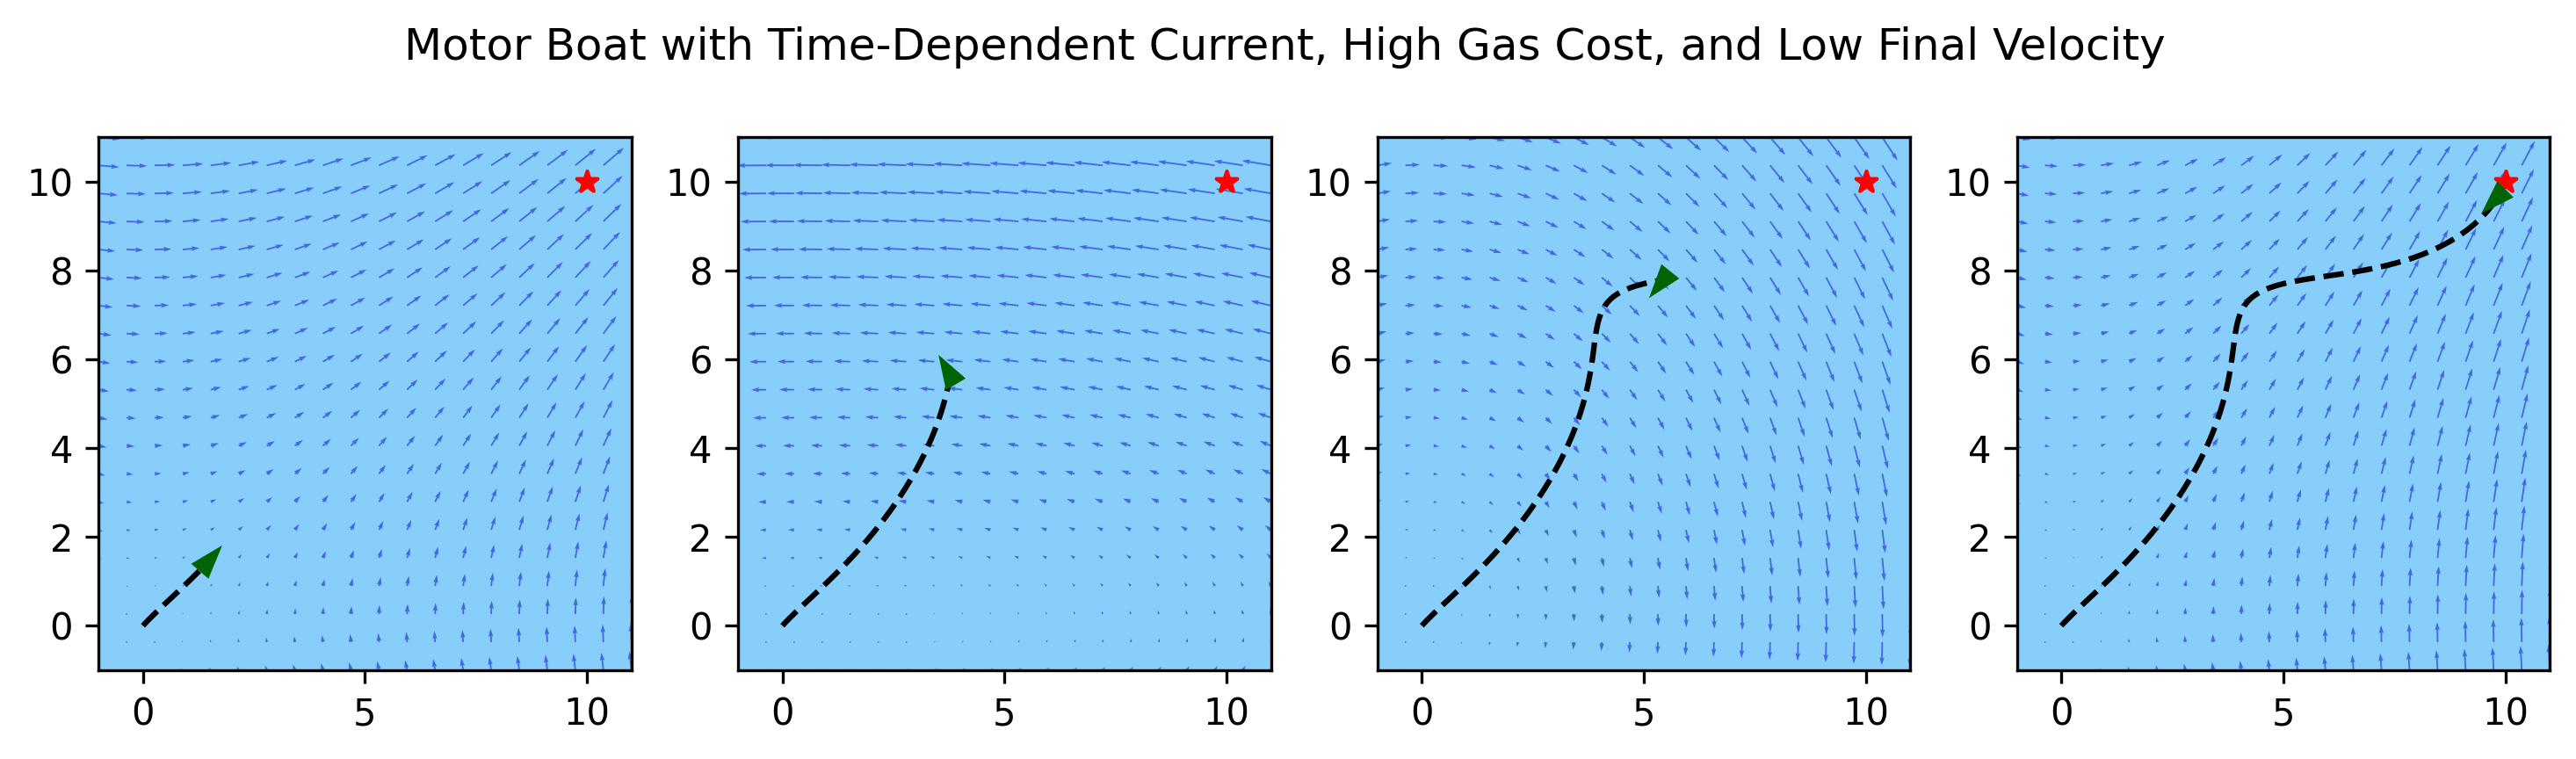

In [23]:
# Get still frames side by side

# Optimal solution calculated in Julia
data = np.load("data/time-dependent-motorboat-high-cost.npz")
print(data)

dt = data['h']
t_steps = 100
t = dt * np.arange(t_steps)
indices = np.arange(t_steps)
t_to_index = {k: v for k, v in zip(t, indices)}
index_to_t = dict()
for time in t_to_index.keys():
    index_to_t[t_to_index[time]] = time

C1 = lambda x, y, t: 0.1 * y * np.sin(0.5*t)
C2 = lambda x, y, t: -0.1 * x * np.cos(0.5*t)

# Boundaries for plot
bottom_left = (0, 0)
top_right = (10, 10)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
plt.suptitle("Motor Boat with Time-Dependent Current, High Gas Cost, and Low Final Velocity")

for i in range(4):
    if i == 0:
        idx = 25
        t = index_to_t[idx]
    elif i == 1:
        idx = 50
        t = index_to_t[idx]
    elif i == 2:
        idx = 75
        t = index_to_t[idx]
    elif i == 3:
        idx = 98
        t = index_to_t[idx]

    axs[i].set_xlim(bottom_left[0] - 1, top_right[0] + 1)
    axs[i].set_ylim(bottom_left[1] - 1, top_right[1] + 1)
    x_path = data['x'][:t_to_index[t]]
    y_path = data['y'][:t_to_index[t]]
    axs[i].set_facecolor("lightskyblue") # background color
    axs[i].scatter(10, 10, c="red", marker="*", zorder=2)
    axs[i].plot(x_path, y_path, "k--", zorder=2)
    angle = data['u1'][t_to_index[t]]
    opt_triangle_coords = create_boat(center=(x_path[-1], y_path[-1]), size=0.2, theta=angle)
    opt_triangle_patch = patches.Polygon(opt_triangle_coords, closed=True, color="darkgreen", zorder=3)
    axs[i].add_patch(opt_triangle_patch)
    x, y = np.meshgrid(np.linspace(bottom_left[0] - 1, top_right[0] + 1, 20), np.linspace(bottom_left[1] - 1, top_right[1] + 1, 20))
    u = C1(x, y, t) # x component of current
    v = C2(x, y, t) # y component of current
    axs[i].quiver(x, y, u, v, color="royalblue", zorder=1)

    axs[i].set_aspect('equal')
plt.show()

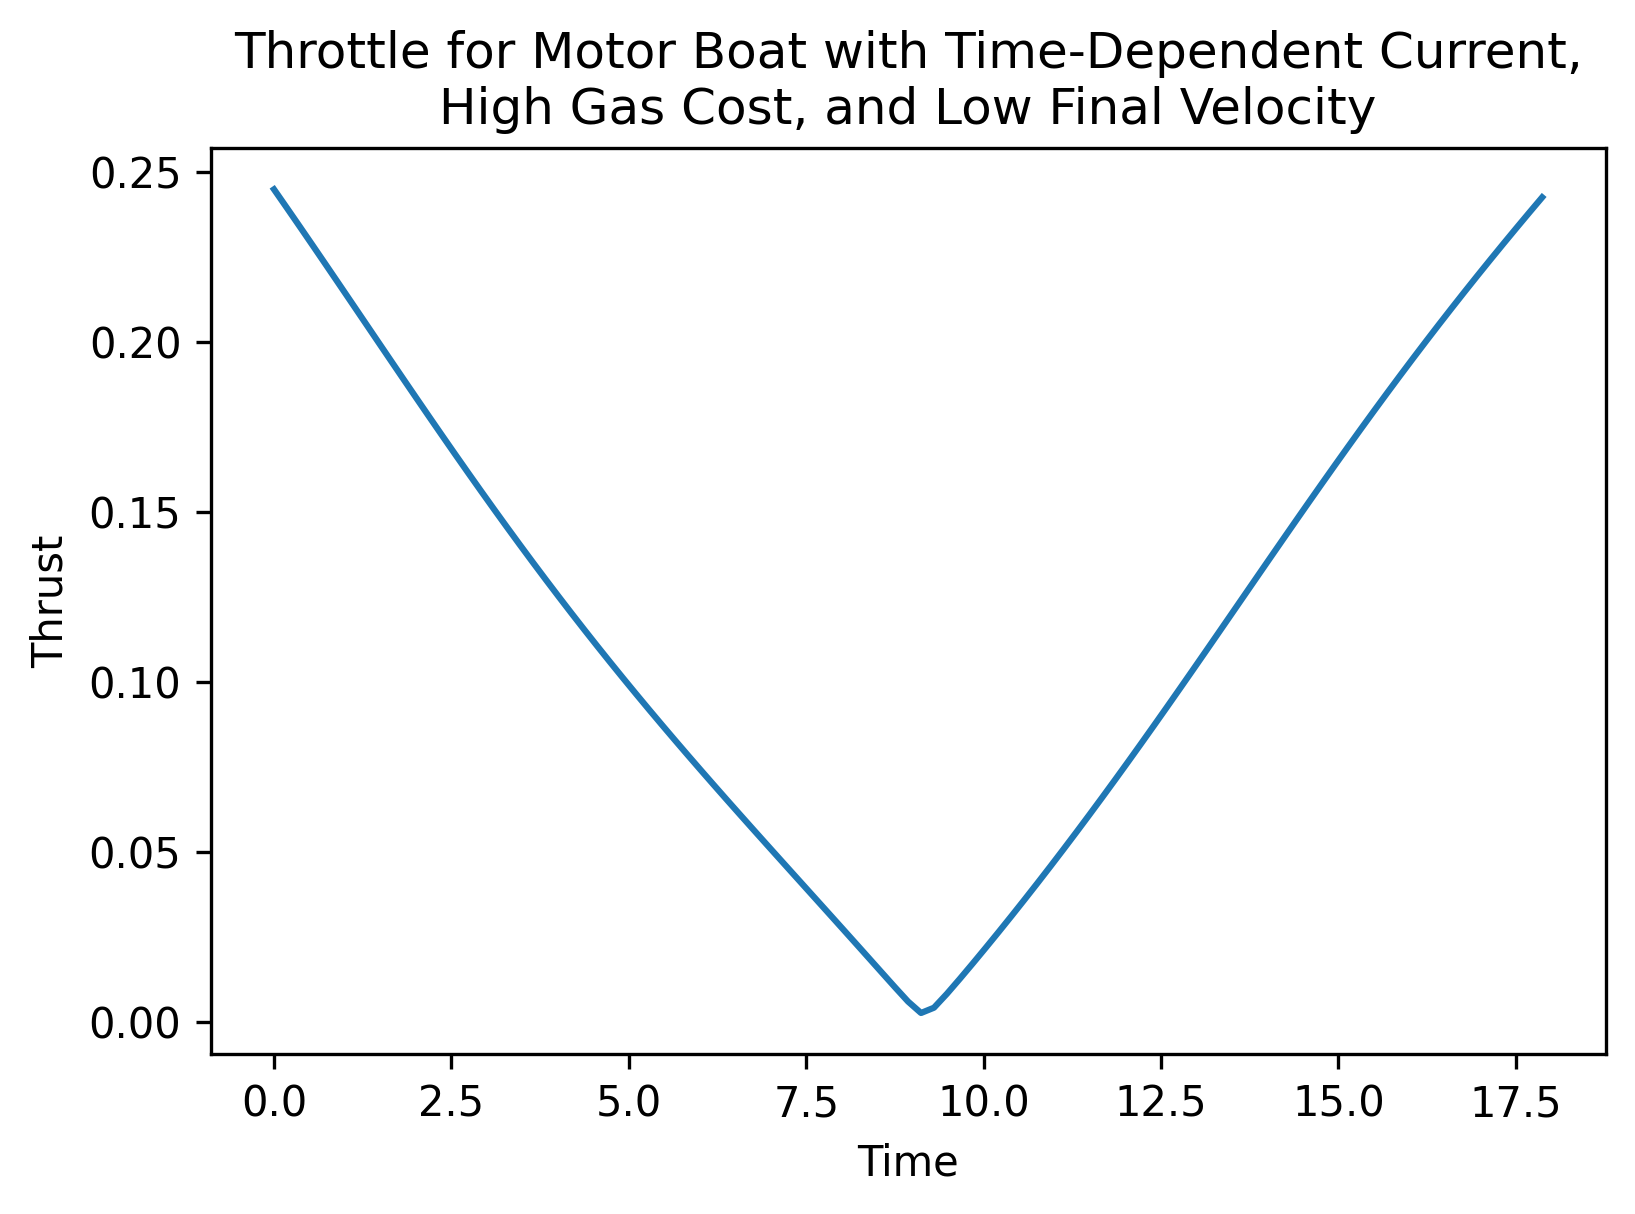

In [ ]:
# Plot motor speed over time (assuming stopping with zero velocity)
plt.title("Throttle for Motorboat with Time-Dependent Current,\nHigh Gas Cost, and Low Final Velocity")
plt.plot(t[:-1], data['u2'])
plt.xlabel("Time")
plt.ylabel("Thrust")
plt.show()

In [ ]:
# Optimal solution calculated in Julia
data = np.load("data/time-dependent-motorboat-low-cost.npz")
print(data)

dt = data['h']
t_steps = 100
t = dt * np.arange(t_steps)
indices = np.arange(t_steps)
t_to_index = {k: v for k, v in zip(t, indices)}

C1 = lambda x, y, t: 0.1 * y * np.sin(0.5*t)
C2 = lambda x, y, t: -0.1 * x * np.cos(0.5*t)

# Boundaries for plot
bottom_left = (0, 0)
top_right = (10, 10)

x_path = []
y_path = []
fig = plt.figure()
def update(t):
    ax = plt.gca()
    ax.clear()
    ax.set_title("Motorboat with Time-Dependent Current,\nLow Gas Cost, and Low Final Velocity")
    ax.set_xlim(bottom_left[0] - 1, top_right[0] + 2)
    ax.set_ylim(bottom_left[1] - 1, top_right[1] + 1)
    x_path.append(data['x'][t_to_index[t]])
    y_path.append(data['y'][t_to_index[t]])

    ### Plot ###
    ax.set_facecolor("lightskyblue") # background color

    # Plot finish
    ax.scatter(10, 10, c="red", marker="*", zorder=2)

    # Plot boat path
    ax.plot(x_path, y_path, "k--", zorder=2)

    # Plot boat
    angle = data['u1'][t_to_index[t]]
    opt_triangle_coords = create_boat(center=(x_path[-1], y_path[-1]), size=0.1, theta=angle)
    opt_triangle_patch = patches.Polygon(opt_triangle_coords, closed=True, color="darkgreen", zorder=3)
    ax.add_patch(opt_triangle_patch)

    # Plot currents
    x, y = np.meshgrid(np.linspace(bottom_left[0] - 1, top_right[0] + 2, 20), np.linspace(bottom_left[1] - 1, top_right[1] + 1, 20))
    u = C1(x, y, t) # x component of current
    v = C2(x, y, t) # y component of current
    ax.quiver(x, y, u, v, color="royalblue", zorder=1)

    plt.gca().set_aspect('equal')

# animation = FuncAnimation(fig, func=update, frames=t[:-1], interval=100)
# animation.save("results/motor-low-cost.mp4", dpi=300)


NpzFile 'data/time-dependent-motorboat-low-cost.npz' with keys: x, u2, u1, h, y


<Figure size 1800x1200 with 0 Axes>

<video src="results/motor-low-cost.mp4" controls> 

NpzFile 'data/time-dependent-motorboat-low-cost.npz' with keys: x, u2, u1, h, y


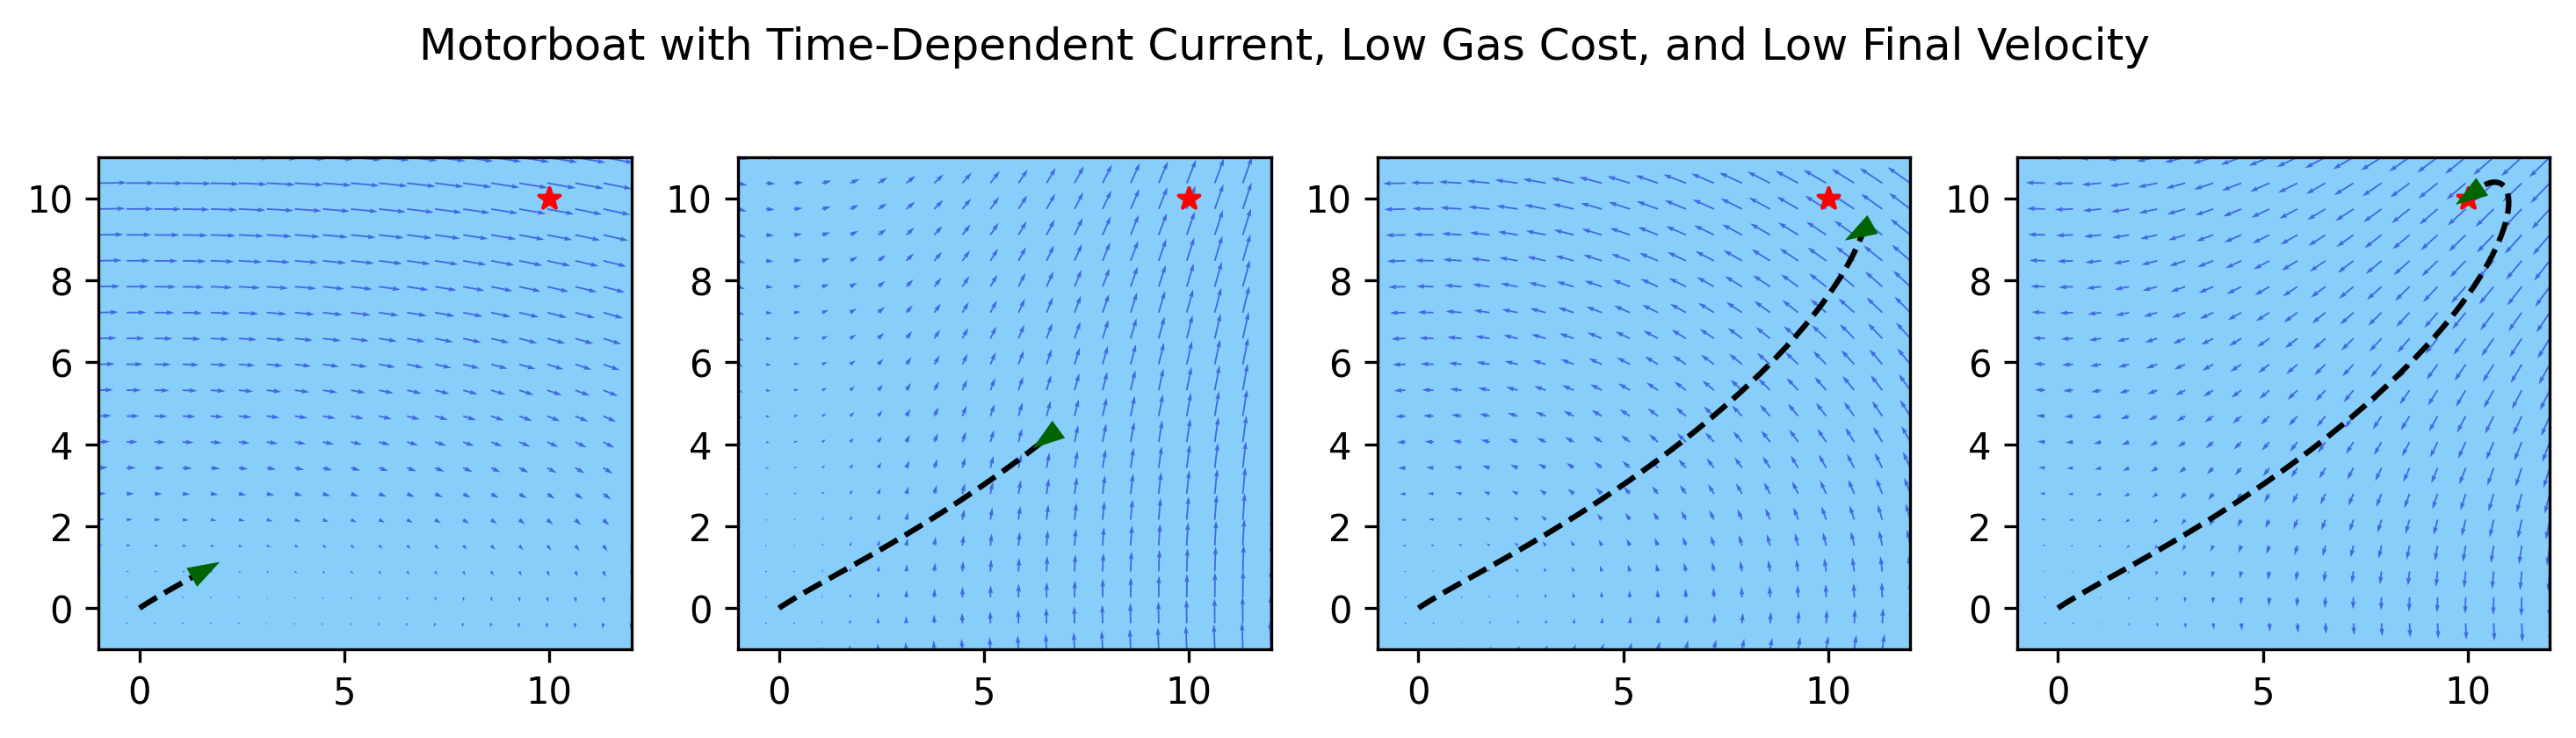

In [24]:
# Get still frames side by side

# Optimal solution calculated in Julia
data = np.load("data/time-dependent-motorboat-low-cost.npz")
print(data)

dt = data['h']
t_steps = 100
t = dt * np.arange(t_steps)
indices = np.arange(t_steps)
t_to_index = {k: v for k, v in zip(t, indices)}
index_to_t = dict()
for time in t_to_index.keys():
    index_to_t[t_to_index[time]] = time

C1 = lambda x, y, t: 0.1 * y * np.sin(0.5*t)
C2 = lambda x, y, t: -0.1 * x * np.cos(0.5*t)

# Boundaries for plot
bottom_left = (0, 0)
top_right = (10, 10)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
plt.suptitle("Motorboat with Time-Dependent Current, Low Gas Cost, and Low Final Velocity")

for i in range(4):
    if i == 0:
        idx = 25
        t = index_to_t[idx]
    elif i == 1:
        idx = 50
        t = index_to_t[idx]
    elif i == 2:
        idx = 75
        t = index_to_t[idx]
    elif i == 3:
        idx = 98
        t = index_to_t[idx]

    axs[i].set_xlim(bottom_left[0] - 1, top_right[0] + 2)
    axs[i].set_ylim(bottom_left[1] - 1, top_right[1] + 1)
    x_path = data['x'][:t_to_index[t]]
    y_path = data['y'][:t_to_index[t]]
    axs[i].set_facecolor("lightskyblue") # background color
    axs[i].scatter(10, 10, c="red", marker="*", zorder=2)
    axs[i].plot(x_path, y_path, "k--", zorder=2)
    angle = data['u1'][t_to_index[t]]
    opt_triangle_coords = create_boat(center=(x_path[-1], y_path[-1]), size=0.2, theta=angle)
    opt_triangle_patch = patches.Polygon(opt_triangle_coords, closed=True, color="darkgreen", zorder=3)
    axs[i].add_patch(opt_triangle_patch)
    x, y = np.meshgrid(np.linspace(bottom_left[0] - 1, top_right[0] + 2, 20), np.linspace(bottom_left[1] - 1, top_right[1] + 1, 20))
    u = C1(x, y, t) # x component of current
    v = C2(x, y, t) # y component of current
    axs[i].quiver(x, y, u, v, color="royalblue", zorder=1)

    axs[i].set_aspect('equal')
plt.show()

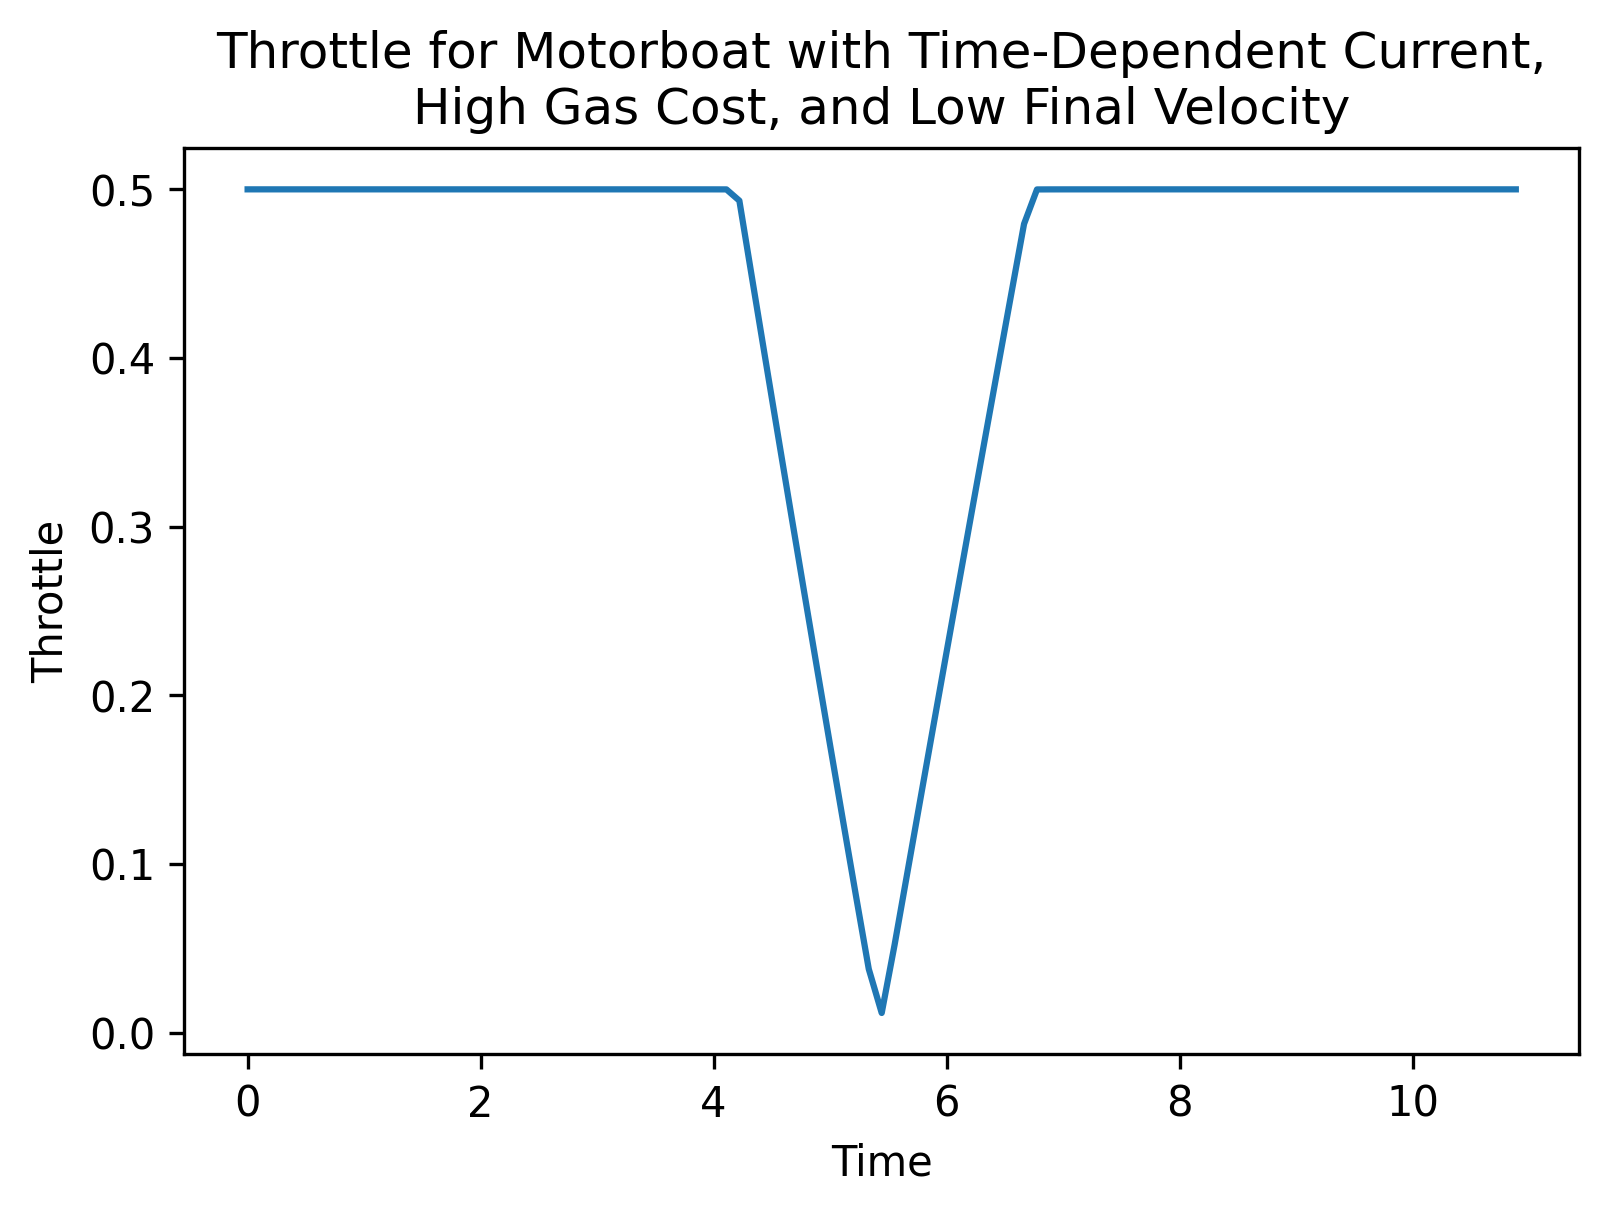

In [22]:
# Plot motor speed over time (assuming stopping with zero velocity)
plt.title("Throttle for Motorboat with Time-Dependent Current,\nHigh Gas Cost, and Low Final Velocity")
plt.plot(t[:-1], data['u2'])
plt.xlabel("Time")
plt.ylabel("Throttle")
plt.show()

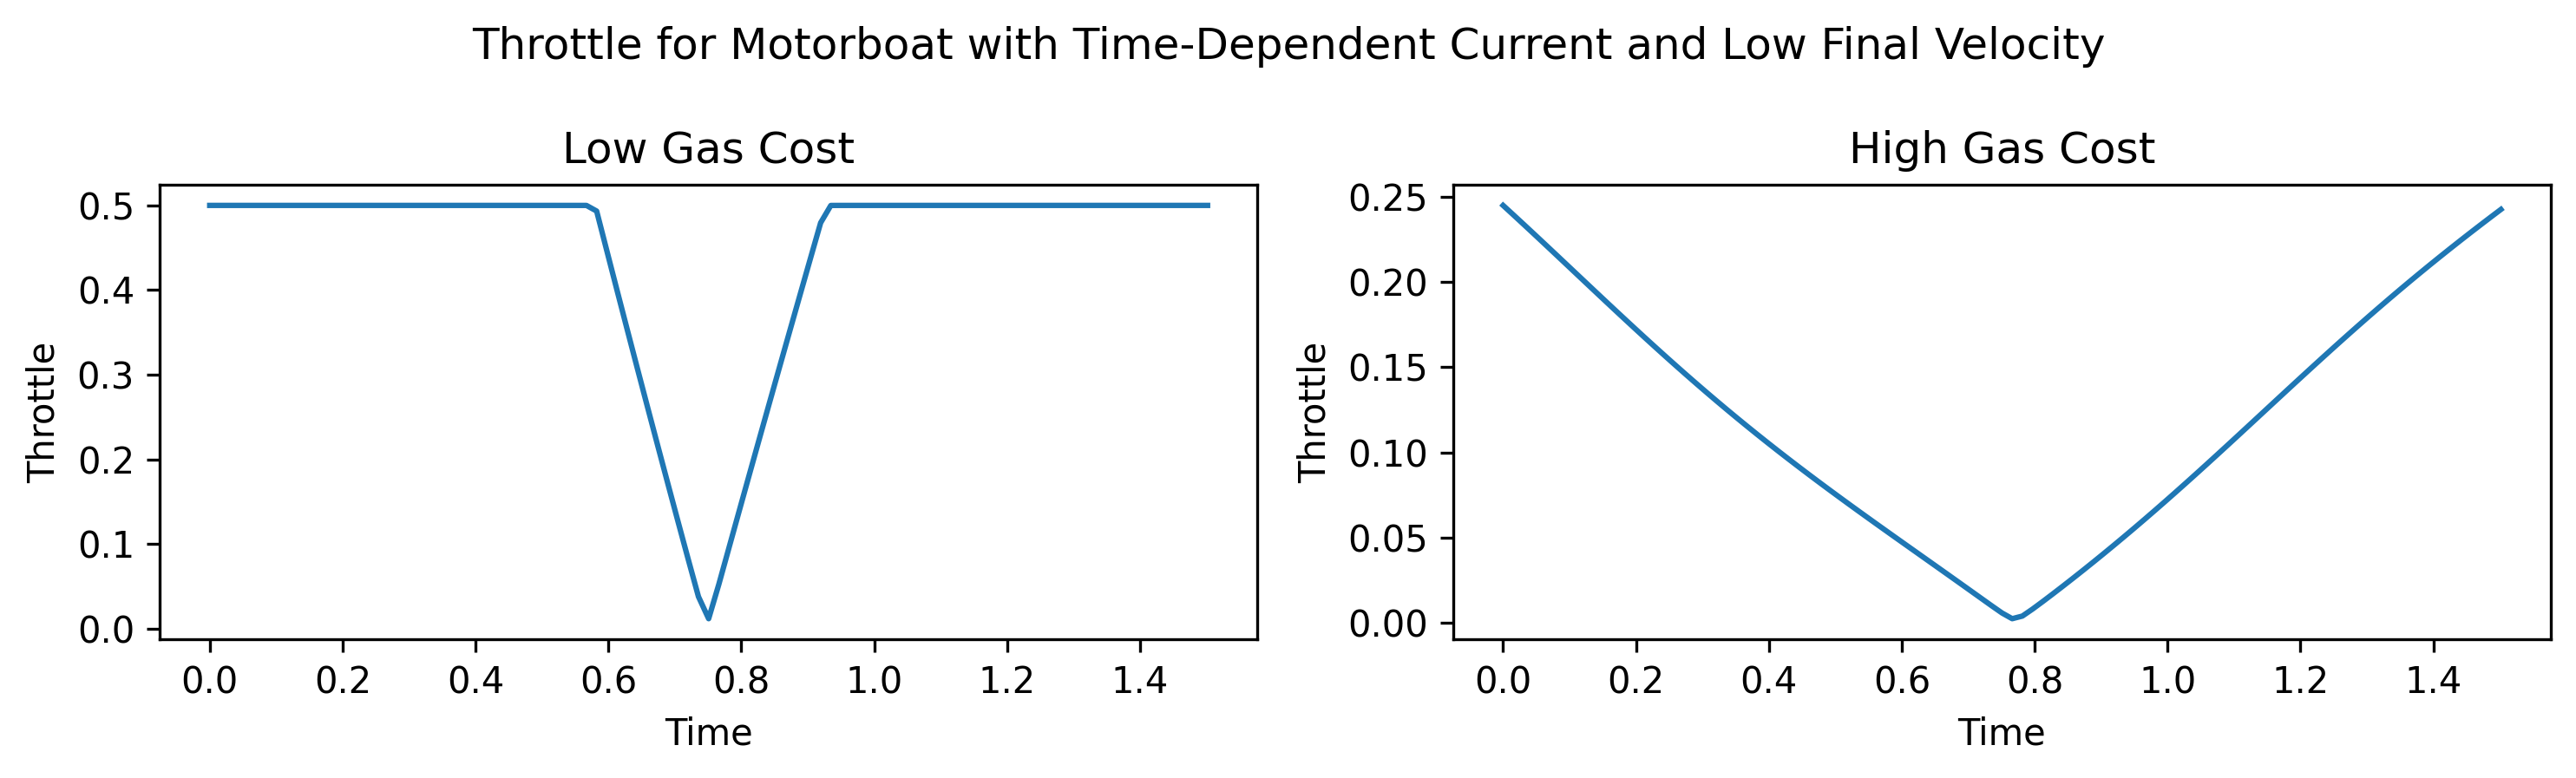

In [26]:
# Comparative throttle
low_data = np.load("data/time-dependent-motorboat-low-cost.npz")
low_dt = low_data['h']
low_t_steps = 100
low_t = dt * np.arange(low_t_steps)
high_data = np.load("data/time-dependent-motorboat-high-cost.npz")
high_dt = low_data['h']
high_t_steps = 100
high_t = dt * np.arange(high_t_steps)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
plt.suptitle("Throttle for Motorboat with Time-Dependent Current and Low Final Velocity")

axs[0].set_title("Low Gas Cost")
axs[0].plot(low_t[:-1], low_data['u2'])
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Throttle")

axs[1].set_title("High Gas Cost")
axs[1].plot(high_t[:-1], high_data['u2'])
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Throttle")

plt.tight_layout()
plt.show()

NpzFile 'data/sailboat-no-motor.npz' with keys: x, u2, u1, h, y


/home/abraham-harris/.local/lib/python3.10/site-packages/matplotlib/quiver.py:649: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/abraham-harris/.local/lib/python3.10/site-packages/matplotlib/quiver.py:649: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


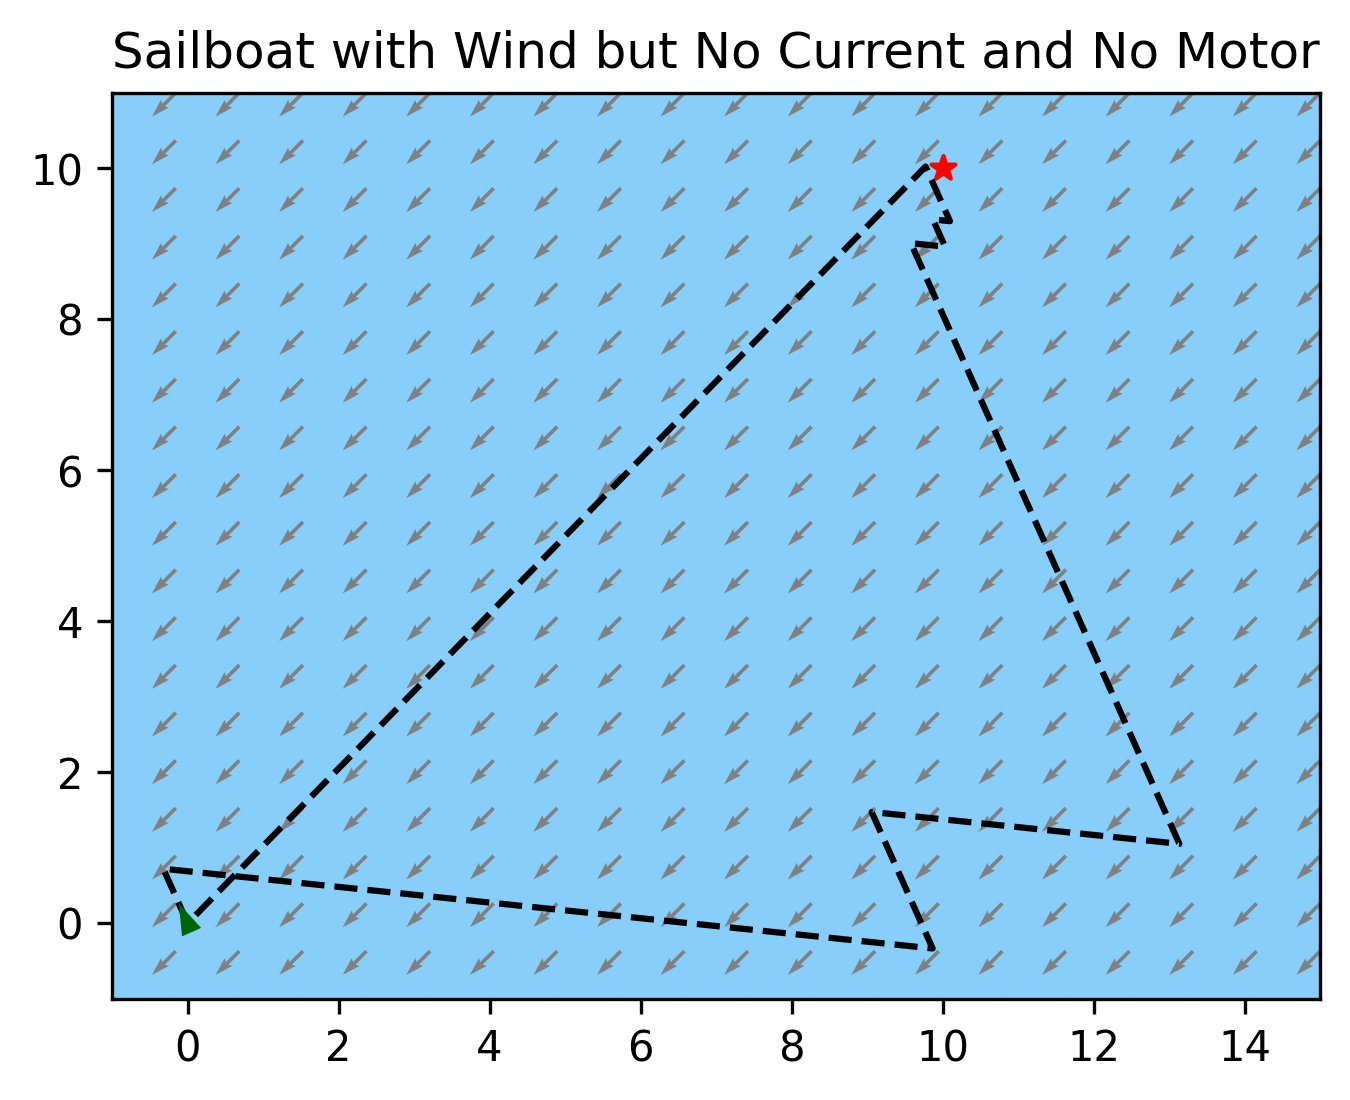

In [15]:
# Optimal solution calculated in Julia
data = np.load("data/sailboat-no-motor.npz")
print(data)

dt = data['h']
t_steps = 100
t = dt * np.arange(t_steps)
indices = np.arange(t_steps)
t_to_index = {k: v for k, v in zip(t, indices)}

C1 = lambda x, y, t: 0
C2 = lambda x, y, t: 0

# Boundaries for plot
bottom_left = (0, 0)
top_right = (10, 10)

x_path = []
y_path = []
fig, ax = plt.subplots()
def update(t):
    ax = plt.gca()
    ax.clear()
    ax.set_title("Sailboat with Wind but No Current and No Motor")
    ax.set_xlim(bottom_left[0] - 1, top_right[0] + 5)
    ax.set_ylim(bottom_left[1] - 1, top_right[1] + 1)
    x_path.append(data['x'][t_to_index[t]])
    y_path.append(data['y'][t_to_index[t]])

    ### Plot ###
    ax.set_facecolor("lightskyblue") # background color

    # Plot finish
    ax.scatter(10, 10, c="red", marker="*", zorder=2)

    # Plot boat path
    ax.plot(x_path, y_path, "k--", zorder=2)

    # Plot boat
    angle = data['u1'][t_to_index[t]]
    opt_triangle_coords = create_boat(center=(x_path[-1], y_path[-1]), size=0.1, theta=angle)
    opt_triangle_patch = patches.Polygon(opt_triangle_coords, closed=True, color="darkgreen", zorder=3)
    ax.add_patch(opt_triangle_patch)

    # Plot currents
    x, y = np.meshgrid(np.linspace(bottom_left[0] - 1, top_right[0] + 5, 20), np.linspace(bottom_left[1] - 1, top_right[1] + 1, 20))
    u = C1(x, y, t) # x component of current
    v = C2(x, y, t) # y component of current
    ax.quiver(x, y, u, v, color="royalblue", zorder=1)

    # Plot winds
    x, y = np.meshgrid(np.linspace(bottom_left[0] - 1, top_right[0] + 5, 20), np.linspace(bottom_left[1] - 1, top_right[1] + 1, 20))
    u = -0.6 # x component of current
    v = -0.6 # y component of current
    ax.quiver(x, y, u, v, color="gray", zorder=1)

    plt.gca().set_aspect('equal')

animation = FuncAnimation(fig, func=update, frames=t[:-1], interval=100)
animation.save("results/sailboat-no-motor-no-current.mp4", dpi=300)

<video src="results/sailboat-no-motor-no-current.mp4" controls>  

NpzFile 'data/sailboat-no-motor.npz' with keys: x, u2, u1, h, y


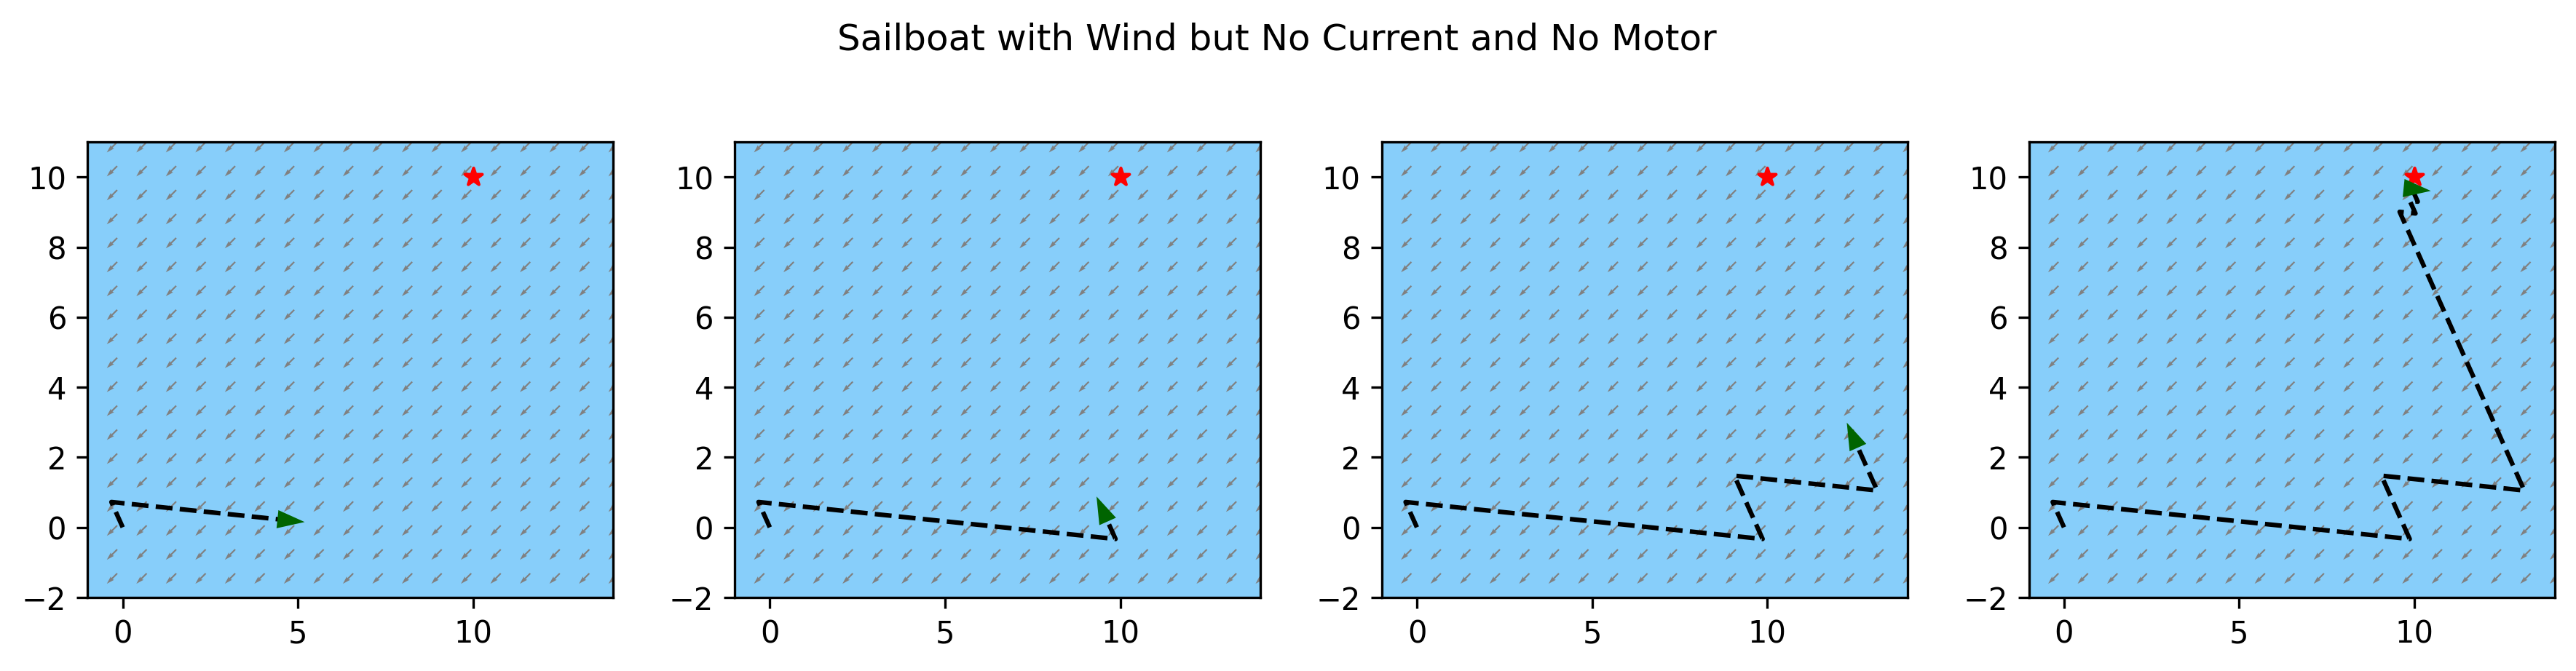

In [17]:
# Get still frames side by side

# Optimal solution calculated in Julia
data = np.load("data/sailboat-no-motor.npz")
print(data)

dt = data['h']
t_steps = 100
t = dt * np.arange(t_steps)
indices = np.arange(t_steps)
t_to_index = {k: v for k, v in zip(t, indices)}
index_to_t = dict()
for time in t_to_index.keys():
    index_to_t[t_to_index[time]] = time

C1 = lambda x, y, t: 0.1 * y * np.sin(0.5*t)
C2 = lambda x, y, t: -0.1 * x * np.cos(0.5*t)

# Boundaries for plot
bottom_left = (0, 0)
top_right = (10, 10)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
plt.suptitle("Sailboat with Wind but No Current and No Motor")

for i in range(4):
    if i == 0:
        idx = 25
        t = index_to_t[idx]
    elif i == 1:
        idx = 50
        t = index_to_t[idx]
    elif i == 2:
        idx = 75
        t = index_to_t[idx]
    elif i == 3:
        idx = 98
        t = index_to_t[idx]

    axs[i].set_xlim(bottom_left[0] - 1, top_right[0] + 4)
    axs[i].set_ylim(bottom_left[1] - 2, top_right[1] + 1)
    x_path = data['x'][:t_to_index[t]]
    y_path = data['y'][:t_to_index[t]]
    axs[i].set_facecolor("lightskyblue") # background color
    axs[i].scatter(10, 10, c="red", marker="*", zorder=2)
    axs[i].plot(x_path, y_path, "k--", zorder=2)
    angle = data['u1'][t_to_index[t]]
    opt_triangle_coords = create_boat(center=(x_path[-1], y_path[-1]), size=0.2, theta=angle)
    opt_triangle_patch = patches.Polygon(opt_triangle_coords, closed=True, color="darkgreen", zorder=3)
    axs[i].add_patch(opt_triangle_patch)
    x, y = np.meshgrid(np.linspace(bottom_left[0] - 1, top_right[0] + 5, 20), np.linspace(bottom_left[1] - 2, top_right[1] + 1, 20))
    u = -0.6 # x component of current
    v = -0.6 # y component of current
    axs[i].quiver(x, y, u, v, color="gray", zorder=1)

    axs[i].set_aspect('equal')
plt.tight_layout()
plt.show()

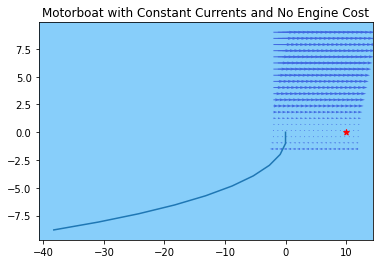

In [36]:
# Plot bang-bang problem (simplest case)

tf = 1 # must solve for this later
t = np.linspace(0.0001, tf, 10)

# Optimal control
u = lambda t: np.arctan(1 / -t)

# Update state
s = np.array([0, 0])
state_tracker = [s]
for t_val in t:
    s = s + np.array([s[1] + np.cos(u(t_val)),
                      np.sin(u(t_val))])
    state_tracker.append(s)
state_tracker = np.array(state_tracker)

# Plot
fig, ax = plt.subplots()
plt.title("Motorboat with Constant Currents and No Engine Cost")
ax.set_facecolor("lightskyblue")

top_right = (11, 8)
bottom_left = (-1, -0.5)

x, y = np.meshgrid(np.linspace(bottom_left[0] - 1, top_right[0] + 1, 20), np.linspace(bottom_left[1] - 1, top_right[1] + 1, 20))
u = y # x component of current
v = 0 # y component of current
plt.quiver(x, y, u, v, color="royalblue", zorder=1)

plt.scatter(10, 0, c="r", marker="*", zorder=2)
plt.plot(state_tracker[:, 0], state_tracker[:, 1])

plt.show()